# Algorithm Convergence
In this notebook, we explore the theoretical guarantees of oru algorithm. In particular, we check to make sure that oru algorithm error bounds hold as we increase the number of smaples that fall within the truncation set.

In [1]:
import sys 
sys.path.append('..')
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 
import IPython

from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle

TABLE_NAME = 'logs'

# Experiment Hyperparameters
Here, are the hyperparameters that you can use for modify for each run of the experiment. Please make sure to fill in teh out_dir and exp keys in the dictionary

In [6]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "lr": 1e-1,
    "var_": 1,
    "trials": 3,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    'out_dir': '<FILL IN OUT_DIR HERE>' 
    'exp': '<FILL IN EXP HERE>', 
    'bs': 10, 
    'steps': 2500, 
    'step_lr': 100, 
    'step_lr_gamma': .9, 
    'tol': 1e-2, 
    'trials': 20, 
    'n': 100,
})
mse_loss = ch.nn.MSELoss()

In [7]:
def run_trial(kwargs, X, y):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > 3e-1) and attempt < 3:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time  

In [10]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 10, 1

# distribution for generating feature vectors
dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
samples = [10, 25, 50, 100, 125, 150, 175, 200, 225, 250, 275, 300, 400, 500, 750, 1000, 1500, 2000, 2500, 3000, 5000]
phi = oracle.Left(1.0)
noise_var = Tensor([1.0])

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(ch.ones(k, d))
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None

# generate data until max number of samples fall within the truncation set
X, noised = Tensor([]), Tensor([])
all_x_trunc, all_y_trunc = Tensor([]), Tensor([])
with ch.no_grad():
    while all_x_trunc.size(0) < samples[-1]: 
        x_ = dist.sample(ch.Size([samples[-1], d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([samples[-1]]))
        new_noised = gt(x_) + ch.sqrt(noise_var) * ch.randn(samples[-1], 1)
        # add noise to ground-truth pedictions
        # truncate based off of the standardized data
        indices = phi(new_noised).flatten().nonzero(as_tuple=False).flatten()
        all_y_trunc, all_x_trunc = ch.cat([all_y_trunc, new_noised[indices]]), ch.cat([all_x_trunc, x_[indices]])
        X, noised = ch.cat([X, x_]), ch.cat([noised, new_noised])
        
alpha = Tensor([all_y_trunc.size(0) / noised.size(0)])

for i in range(args.trials):
    # create store and add table
    store = Store(args.out_dir + args.exp)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
            
    # shuffle x_trunc, y_trunc
    rand_perm = ch.randperm(all_y_trunc.size(0))
    x_trunc_pool, y_trunc_pool = all_x_trunc[rand_perm], all_y_trunc[rand_perm]
    
    # iterate over samples
    for s in samples: 
        # take s truncated samples
        x_trunc, y_trunc = x_trunc_pool[:s], y_trunc_pool[:s]

        # 10% of truncated data is validation data
        val = int(.1*s)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with unknown variance. 
        This means that we want to standardize our dependent variable 
        by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        emp_stand_intervals = [(int_[0]/math.sqrt(float(emp_noise_var)), int_[1]/math.sqrt(float(emp_noise_var))) for int_ in intervals]
        emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)        

        # truncated regression with unknown variance
        unknown_kwargs = { 
            'phi': oracle.Left(phi.left / ch.sqrt(emp_noise_var)), 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc)
        unknown_var = unknown_trunc_reg.variance * emp_noise_var
        w, w0 = (((unknown_trunc_reg.weight) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var)))
        unknown_params = ch.cat([w, w0]).flatten()

        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': total_time, 
        })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })
        IPython.display.clear_output()


        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /Users/patroklos/regressionConverge/b0828706-33d8-431e-9499-6b4d1c2ff9fd
Iteration 1 | Score: 12045272481792.0
Iteration 2 | Score: 12045272481792.0
Iteration 3 | Score: 12045272481792.0
Iteration 4 | Score: 12045272481792.0
Iteration 5 | Score: 12045272481792.0
Iteration 6 | Score: 12045272481792.0
Iteration 7 | Score: 12045272481792.0
Iteration 8 | Score: 12045272481792.0
Iteration 9 | Score: 12045272481792.0
Iteration 10 | Score: 12045272481792.0
Iteration 11 | Score: 12045272481792.0
Iteration 12 | Score: 12045272481792.0
Iteration 13 | Score: 12045272481792.0
Iteration 14 | Score: 12045272481792.0
Iteration 15 | Score: 12045272481792.0
Iteration 16 | Score: 12045272481792.0
Iteration 17 | Score: 12045272481792.0
Iteration 18 | Score: 12045272481792.0
Iteration 19 | Score: 12045272481792.0
Iteration 20 | Score: 12045272481792.0
Iteration 21 | Score: 12045272481792.0
Iteration 22 | Score: 12045272481792.0
Iteration 23 | Score: 12045272481792.0
Iteration 24 | Score: 12045

Iteration 8 | Score: 2.4216983318328857
Iteration 9 | Score: 2.7868542671203613
Iteration 10 | Score: 3.746483564376831
Iteration 11 | Score: 2.7863879203796387
Iteration 12 | Score: 2.506749153137207
Iteration 13 | Score: 3.9883434772491455
Iteration 14 | Score: 3.932448387145996
Iteration 15 | Score: 2.283298969268799
Iteration 16 | Score: 1.38835871219635
Iteration 17 | Score: 2.3010246753692627
Iteration 18 | Score: 2.7130069732666016
Iteration 19 | Score: 3.5449588298797607
Iteration 20 | Score: 2.5117909908294678
Iteration 21 | Score: 2.198397636413574
Iteration 22 | Score: 3.9120640754699707
Iteration 23 | Score: 3.608736276626587
Iteration 24 | Score: 2.6498970985412598
Iteration 25 | Score: 1.3544740676879883
Iteration 1 | Score: 1.009119987487793
Iteration 2 | Score: 5.317225933074951
Iteration 3 | Score: 0.6036778092384338
Iteration 4 | Score: 1.9775831699371338
Iteration 5 | Score: 2.6842916011810303
Iteration 6 | Score: 2.9092180728912354
Iteration 7 | Score: 0.76553070545

Iteration 12 | Score: 2.1415865421295166
Iteration 13 | Score: 1.7009844779968262
Iteration 14 | Score: 7.9827070236206055
Iteration 15 | Score: 2.2742090225219727
Iteration 16 | Score: 1.0075398683547974
Iteration 17 | Score: 0.5305913090705872
Iteration 18 | Score: 1.7486761808395386
Iteration 19 | Score: 2.0981645584106445
Iteration 20 | Score: 1.4335898160934448
Iteration 21 | Score: 8.150997161865234
Iteration 22 | Score: 2.1519525051116943
Iteration 23 | Score: 1.061771035194397
Iteration 24 | Score: 0.27385422587394714
Iteration 25 | Score: 1.6789661645889282
Iteration 1 | Score: 0.21593399345874786
Iteration 2 | Score: 2.4802095890045166
Iteration 3 | Score: 1.2731475830078125
Iteration 4 | Score: 2.2607803344726562
Iteration 5 | Score: 0.10295706987380981
Iteration 6 | Score: 2.5038070678710938
Iteration 7 | Score: 1.6985746622085571
Iteration 8 | Score: 2.2178261280059814
Iteration 9 | Score: 0.08118769526481628
Iteration 10 | Score: 2.4859695434570312
Iteration 11 | Score: 1

Iteration 14 | Score: 0.4938628673553467
Iteration 15 | Score: 1.9177510738372803
Iteration 16 | Score: 0.39310741424560547
Iteration 17 | Score: 0.34833478927612305
Iteration 18 | Score: 0.5400875806808472
Iteration 19 | Score: 0.3380710482597351
Iteration 20 | Score: 0.3364078998565674
Iteration 21 | Score: 0.6154314279556274
Iteration 22 | Score: 0.6659409403800964
Iteration 23 | Score: 1.8428637981414795
Iteration 24 | Score: 1.1583484411239624
Iteration 25 | Score: 1.2948050498962402
Iteration 1 | Score: 0.6695501804351807
Iteration 2 | Score: 1.5603489875793457
Iteration 3 | Score: 1.9230194091796875
Iteration 4 | Score: 0.10251312702894211
Iteration 5 | Score: 0.1473509967327118
Iteration 6 | Score: 0.09006141871213913
Iteration 7 | Score: 1.5064737796783447
Iteration 8 | Score: 0.5132225751876831
Iteration 9 | Score: 0.2524833679199219
Iteration 10 | Score: 0.48020970821380615
Iteration 11 | Score: 0.9418115615844727
Iteration 12 | Score: 0.7348639965057373
Iteration 13 | Score

Iteration 16 | Score: 0.832298755645752
Iteration 17 | Score: 0.8059784173965454
Iteration 18 | Score: 1.5449985265731812
Iteration 19 | Score: 0.3697171211242676
Iteration 20 | Score: 0.3853484094142914
Iteration 21 | Score: 0.8820350170135498
Iteration 22 | Score: 0.9048115611076355
Iteration 23 | Score: 2.2972888946533203
Iteration 24 | Score: 1.7161402702331543
Iteration 25 | Score: 0.8741958737373352
Iteration 1 | Score: 1.8252487182617188
Iteration 2 | Score: 1.0142183303833008
Iteration 3 | Score: 0.12216154485940933
Iteration 4 | Score: 1.060154676437378
Iteration 5 | Score: 0.11738976836204529
Iteration 6 | Score: 0.1590820848941803
Iteration 7 | Score: 0.1865714192390442
Iteration 8 | Score: 1.2331290245056152
Iteration 9 | Score: 0.8362904787063599
Iteration 10 | Score: 1.2142025232315063
Iteration 11 | Score: 0.9792667627334595
Iteration 12 | Score: 0.32235366106033325
Iteration 13 | Score: 1.0741935968399048
Iteration 14 | Score: 0.16531944274902344
Iteration 15 | Score: 0

Iteration 19 | Score: 0.7549794912338257
Iteration 20 | Score: 0.05240825191140175
Iteration 21 | Score: 0.33583498001098633
Iteration 22 | Score: 0.8538171648979187
Iteration 23 | Score: 0.8178720474243164
Iteration 24 | Score: 0.5741351842880249
Iteration 25 | Score: 0.0951717346906662
Iteration 1 | Score: 1.434867262840271
Iteration 2 | Score: 0.13376031816005707
Iteration 3 | Score: 1.1099581718444824
Iteration 4 | Score: 0.7957514524459839
Iteration 5 | Score: 1.529327154159546
Iteration 6 | Score: 0.974105715751648
Iteration 7 | Score: 0.7629095315933228
Iteration 8 | Score: 0.23022249341011047
Iteration 9 | Score: 0.6191520690917969
Iteration 10 | Score: 1.2775747776031494
Iteration 11 | Score: 0.14688248932361603
Iteration 12 | Score: 1.0183486938476562
Iteration 13 | Score: 0.7730295062065125
Iteration 14 | Score: 1.6027592420578003
Iteration 15 | Score: 1.0695844888687134
Iteration 16 | Score: 0.7368600964546204
Iteration 17 | Score: 0.09403528273105621
Iteration 18 | Score: 

Iteration 1 | Score: 1.1506171226501465
Iteration 2 | Score: 0.599186897277832
Iteration 3 | Score: 0.5377010703086853
Iteration 4 | Score: 0.09787718951702118
Iteration 5 | Score: 0.73317551612854
Iteration 6 | Score: 0.7544478178024292
Iteration 7 | Score: 1.1339476108551025
Iteration 8 | Score: 0.9659597277641296
Iteration 9 | Score: 0.5865538120269775
Iteration 10 | Score: 1.0727277994155884
Iteration 11 | Score: 0.5379988551139832
Iteration 12 | Score: 0.425665020942688
Iteration 13 | Score: 0.1798211634159088
Iteration 14 | Score: 0.6371140480041504
Iteration 15 | Score: 0.7095385789871216
Iteration 16 | Score: 1.0479851961135864
Iteration 17 | Score: 0.8895332217216492
Iteration 18 | Score: 0.5241283774375916
Iteration 19 | Score: 1.0626128911972046
Iteration 20 | Score: 0.5489500761032104
Iteration 21 | Score: 0.337396502494812
Iteration 22 | Score: 0.29427626729011536
Iteration 23 | Score: 0.8635669350624084
Iteration 24 | Score: 0.6696930527687073
Iteration 25 | Score: 1.1733

Iteration 6 | Score: 0.9306281208992004
Iteration 7 | Score: 1.324144959449768
Iteration 8 | Score: 0.8353258967399597
Iteration 9 | Score: 1.4837757349014282
Iteration 10 | Score: 1.0088127851486206
Iteration 11 | Score: 1.268221139907837
Iteration 12 | Score: 1.2468129396438599
Iteration 13 | Score: 1.1753225326538086
Iteration 14 | Score: 0.7820121645927429
Iteration 15 | Score: 1.2226780652999878
Iteration 16 | Score: 0.7782933712005615
Iteration 17 | Score: 0.758019745349884
Iteration 18 | Score: 1.5815181732177734
Iteration 19 | Score: 1.3784170150756836
Iteration 20 | Score: 1.1803992986679077
Iteration 21 | Score: 1.42637300491333
Iteration 22 | Score: 1.2369379997253418
Iteration 23 | Score: 1.7642543315887451
Iteration 24 | Score: 1.3441697359085083
Iteration 25 | Score: 1.2791248559951782
Iteration 1 | Score: 0.5351068377494812
Iteration 2 | Score: 0.3421250879764557
Iteration 3 | Score: 0.17113251984119415
Iteration 4 | Score: 0.36859986186027527
Iteration 5 | Score: 0.5027

Iteration 10 | Score: 1.293698787689209
Iteration 11 | Score: 0.22500276565551758
Iteration 12 | Score: 0.1927472949028015
Iteration 13 | Score: 0.5017585158348083
Iteration 14 | Score: 0.7910970449447632
Iteration 15 | Score: 0.9375048279762268
Iteration 16 | Score: 0.2553595006465912
Iteration 17 | Score: 0.6989113092422485
Iteration 18 | Score: 0.5504592061042786
Iteration 19 | Score: 0.31696516275405884
Iteration 20 | Score: 0.5171895027160645
Iteration 21 | Score: 0.6134089231491089
Iteration 22 | Score: 1.161361813545227
Iteration 23 | Score: 0.1559058427810669
Iteration 24 | Score: 0.8789880871772766
Iteration 25 | Score: 0.0707009807229042
Iteration 1 | Score: 1.2574294805526733
Iteration 2 | Score: 0.1524481326341629
Iteration 3 | Score: 3.161651849746704
Iteration 4 | Score: 0.7356133460998535
Iteration 5 | Score: 0.0438641756772995
Iteration 6 | Score: 0.7712706327438354
Iteration 7 | Score: 0.39187923073768616
Iteration 8 | Score: 0.7654201984405518
Iteration 9 | Score: 0.0

Iteration 13 | Score: 0.12443419545888901
Iteration 14 | Score: 0.6232888102531433
Iteration 15 | Score: 1.9808969497680664
Iteration 16 | Score: 0.6261619925498962
Iteration 17 | Score: 0.4612920582294464
Iteration 18 | Score: 2.491907835006714
Iteration 19 | Score: 2.120309591293335
Iteration 20 | Score: 0.11397211998701096
Iteration 21 | Score: 0.045715924352407455
Iteration 22 | Score: 1.1971198320388794
Iteration 23 | Score: 1.3843742609024048
Iteration 24 | Score: 0.2558012306690216
Iteration 25 | Score: 1.321431279182434
Iteration 1 | Score: 0.3615850508213043
Iteration 2 | Score: 1.0092984437942505
Iteration 3 | Score: 1.2697837352752686
Iteration 4 | Score: 1.8182041645050049
Iteration 5 | Score: 2.216005802154541
Iteration 6 | Score: 1.1683638095855713
Iteration 7 | Score: 1.5318666696548462
Iteration 8 | Score: 0.4911670684814453
Iteration 9 | Score: 0.7388454079627991
Iteration 10 | Score: 0.375498503446579
Iteration 11 | Score: 1.195591688156128
Iteration 12 | Score: 1.165

Iteration 2 | Score: 0.6001447439193726
Iteration 3 | Score: 1.36076021194458
Iteration 4 | Score: 1.2669154405593872
Iteration 5 | Score: 1.585816740989685
Iteration 6 | Score: 0.8756712675094604
Iteration 7 | Score: 0.09703776985406876
Iteration 8 | Score: 1.2478939294815063
Iteration 9 | Score: 0.7434006929397583
Iteration 10 | Score: 1.2876516580581665
Iteration 11 | Score: 0.8201442956924438
Iteration 12 | Score: 1.275584101676941
Iteration 13 | Score: 1.2978568077087402
Iteration 14 | Score: 1.527582049369812
Iteration 15 | Score: 0.921227753162384
Iteration 16 | Score: 0.31449294090270996
Iteration 17 | Score: 1.2243421077728271
Iteration 18 | Score: 0.8603249788284302
Iteration 19 | Score: 1.3635261058807373
Iteration 20 | Score: 0.6643754243850708
Iteration 21 | Score: 1.3365975618362427
Iteration 22 | Score: 1.1944003105163574
Iteration 23 | Score: 1.4161899089813232
Iteration 24 | Score: 0.9758490324020386
Iteration 25 | Score: 0.38715940713882446
Iteration 1 | Score: 1.3720

Iteration 3 | Score: 0.9097150564193726
Iteration 4 | Score: 1.4241127967834473
Iteration 5 | Score: 11.34691333770752
Iteration 6 | Score: 0.5980038642883301
Iteration 7 | Score: 0.4606429934501648
Iteration 8 | Score: 0.15047995746135712
Iteration 9 | Score: 0.26470109820365906
Iteration 10 | Score: 0.3359270393848419
Iteration 11 | Score: 0.4831666946411133
Iteration 12 | Score: 1.6442126035690308
Iteration 13 | Score: 0.39170345664024353
Iteration 14 | Score: 0.8735617995262146
Iteration 15 | Score: 0.4197145402431488
Iteration 16 | Score: 0.8589908480644226
Iteration 17 | Score: 1.7639031410217285
Iteration 18 | Score: 0.41350123286247253
Iteration 19 | Score: 0.12194211781024933
Iteration 20 | Score: 0.8878315091133118
Iteration 21 | Score: 0.6775339841842651
Iteration 22 | Score: 8.97307300567627
Iteration 23 | Score: 0.791053056716919
Iteration 24 | Score: 0.5591852068901062
Iteration 25 | Score: 0.026019537821412086
Iteration 1 | Score: 0.8571345806121826
Iteration 2 | Score: 

Iteration 3 | Score: 0.1332501471042633
Iteration 4 | Score: 0.9449664354324341
Iteration 5 | Score: 0.609192967414856
Iteration 6 | Score: 0.031958628445863724
Iteration 7 | Score: 0.6478226780891418
Iteration 8 | Score: 0.8020205497741699
Iteration 9 | Score: 0.5422313809394836
Iteration 10 | Score: 0.6663690805435181
Iteration 11 | Score: 0.6874303221702576
Iteration 12 | Score: 1.4236143827438354
Iteration 13 | Score: 0.0509130097925663
Iteration 14 | Score: 0.6996039748191833
Iteration 15 | Score: 0.6986929774284363
Iteration 16 | Score: 1.2274725437164307
Iteration 17 | Score: 0.39515841007232666
Iteration 18 | Score: 0.8945043683052063
Iteration 19 | Score: 0.08708455413579941
Iteration 20 | Score: 0.9065497517585754
Iteration 21 | Score: 2.100496292114258
Iteration 22 | Score: 0.6774280667304993
Iteration 23 | Score: 0.6679443717002869
Iteration 24 | Score: 1.0404943227767944
Iteration 25 | Score: 1.581433653831482
Iteration 26 | Score: 0.45445287227630615
Iteration 27 | Score:

Iteration 3 | Score: 0.4668648838996887
Iteration 4 | Score: 0.5601543188095093
Iteration 5 | Score: 0.43067094683647156
Iteration 6 | Score: 0.2154291719198227
Iteration 7 | Score: 0.6244570016860962
Iteration 8 | Score: 0.5186190605163574
Iteration 9 | Score: 0.3398011028766632
Iteration 10 | Score: 0.6161128282546997
Iteration 11 | Score: 0.11607777327299118
Iteration 12 | Score: 0.8287819623947144
Iteration 13 | Score: 0.8242732882499695
Iteration 14 | Score: 0.043027643114328384
Iteration 15 | Score: 1.0901228189468384
Iteration 16 | Score: 0.8691062927246094
Iteration 17 | Score: 1.9015408754348755
Iteration 18 | Score: 0.6486661434173584
Iteration 19 | Score: 0.9486887454986572
Iteration 20 | Score: 1.225110650062561
Iteration 21 | Score: 1.5020066499710083
Iteration 22 | Score: 0.9860784411430359
Iteration 23 | Score: 1.3320567607879639
Iteration 24 | Score: 0.975363552570343
Iteration 25 | Score: 1.05555260181427
Iteration 1 | Score: 2.30830454826355
Iteration 2 | Score: 1.181

Iteration 5 | Score: 0.7960067391395569
Iteration 6 | Score: 1.047916054725647
Iteration 7 | Score: 1.8047863245010376
Iteration 8 | Score: 2.0732760429382324
Iteration 9 | Score: 0.5867948532104492
Iteration 10 | Score: 1.577248454093933
Iteration 11 | Score: 0.46888482570648193
Iteration 12 | Score: 0.6127744317054749
Iteration 13 | Score: 0.4553413391113281
Iteration 14 | Score: 1.449960708618164
Iteration 15 | Score: 1.943710446357727
Iteration 16 | Score: 0.8294491171836853
Iteration 17 | Score: 1.2423208951950073
Iteration 18 | Score: 0.6755141019821167
Iteration 19 | Score: 0.8279175162315369
Iteration 20 | Score: 0.7718843221664429
Iteration 21 | Score: 2.0009946823120117
Iteration 22 | Score: 2.086623430252075
Iteration 23 | Score: 0.6029253005981445
Iteration 24 | Score: 1.3962349891662598
Iteration 25 | Score: 0.11972560733556747
Iteration 1 | Score: 6.125640869140625
Iteration 2 | Score: 1.3257436752319336
Iteration 3 | Score: 2.081395149230957
Iteration 4 | Score: 0.618090

Iteration 9 | Score: 1.1987043619155884
Iteration 10 | Score: 0.20944827795028687
Iteration 11 | Score: 0.3572213649749756
Iteration 12 | Score: 0.7776691913604736
Iteration 13 | Score: 0.7476029992103577
Iteration 14 | Score: 0.3366234600543976
Iteration 15 | Score: 2.7185168266296387
Iteration 16 | Score: 0.5143649578094482
Iteration 17 | Score: 0.9231104254722595
Iteration 18 | Score: 0.2820513844490051
Iteration 19 | Score: 1.0350966453552246
Iteration 20 | Score: 3.893078088760376
Iteration 21 | Score: 0.7896125912666321
Iteration 22 | Score: 1.97906494140625
Iteration 23 | Score: 0.7641366124153137
Iteration 24 | Score: 0.8776766657829285
Iteration 25 | Score: 0.25778868794441223
Iteration 1 | Score: 1.9185802936553955
Iteration 2 | Score: 1.2520607709884644
Iteration 3 | Score: 0.8983142375946045
Iteration 4 | Score: 1.3549798727035522
Iteration 5 | Score: 1.0754050016403198
Iteration 6 | Score: 0.032208848744630814
Iteration 7 | Score: 1.147476315498352
Iteration 8 | Score: 3.3

Iteration 11 | Score: 2.022292137145996
Iteration 12 | Score: 0.16868643462657928
Iteration 13 | Score: 1.1259859800338745
Iteration 14 | Score: 0.9440434575080872
Iteration 15 | Score: 0.05063103511929512
Iteration 16 | Score: 1.1729767322540283
Iteration 17 | Score: 0.07539483159780502
Iteration 18 | Score: 0.34021732211112976
Iteration 19 | Score: 0.2430042326450348
Iteration 20 | Score: 1.5639621019363403
Iteration 21 | Score: 4.234436988830566
Iteration 22 | Score: 1.0730069875717163
Iteration 23 | Score: 1.5574498176574707
Iteration 24 | Score: 0.8207948803901672
Iteration 25 | Score: 0.6490810513496399
Iteration 1 | Score: 0.3574419617652893
Iteration 2 | Score: 3.591085433959961
Iteration 3 | Score: 0.6693263053894043
Iteration 4 | Score: 0.8462441563606262
Iteration 5 | Score: 2.921731948852539
Iteration 6 | Score: 0.5721630454063416
Iteration 7 | Score: 1.1233763694763184
Iteration 8 | Score: 2.9201302528381348
Iteration 9 | Score: 0.18812286853790283
Iteration 10 | Score: 0.

Iteration 13 | Score: 0.9619239568710327
Iteration 14 | Score: 0.3949316442012787
Iteration 15 | Score: 0.9700558185577393
Iteration 16 | Score: 0.1504681259393692
Iteration 17 | Score: 1.073964238166809
Iteration 18 | Score: 0.7835938334465027
Iteration 19 | Score: 0.5723073482513428
Iteration 20 | Score: 0.9890921711921692
Iteration 21 | Score: 1.252807855606079
Iteration 22 | Score: 0.42778345942497253
Iteration 23 | Score: 1.1850863695144653
Iteration 24 | Score: 0.7901190519332886
Iteration 25 | Score: 1.58042311668396
Iteration 1 | Score: 0.7254179120063782
Iteration 2 | Score: 0.8299310803413391
Iteration 3 | Score: 1.0280262231826782
Iteration 4 | Score: 0.1985480636358261
Iteration 5 | Score: 0.3929373323917389
Iteration 6 | Score: 0.20288072526454926
Iteration 7 | Score: 0.8989444375038147
Iteration 8 | Score: 0.6370419859886169
Iteration 9 | Score: 0.6184160113334656
Iteration 10 | Score: 3.905508279800415
Iteration 11 | Score: 1.132236123085022
Iteration 12 | Score: 0.66820

Iteration 11 | Score: 0.16497226059436798
Iteration 12 | Score: 0.04271354526281357
Iteration 13 | Score: 0.3349619507789612
Iteration 14 | Score: 1.0704189538955688
Iteration 15 | Score: 0.12303590029478073
Iteration 16 | Score: 0.6634091734886169
Iteration 17 | Score: 0.6362489461898804
Iteration 18 | Score: 0.7943124771118164
Iteration 19 | Score: 0.5708704590797424
Iteration 20 | Score: 0.30573761463165283
Iteration 21 | Score: 0.24643419682979584
Iteration 22 | Score: 0.2838018834590912
Iteration 23 | Score: 0.9650927782058716
Iteration 24 | Score: 0.14407800137996674
Iteration 25 | Score: 0.7603083252906799
Iteration 26 | Score: 0.5898069739341736
Iteration 27 | Score: 0.7406049370765686
Logging in: /Users/patroklos/regressionConverge/45e9e9a7-cd82-4365-89da-8fd3cbf6496f
Iteration 1 | Score: 4860682436608.0
Iteration 2 | Score: 4860682436608.0
Iteration 3 | Score: 4860682436608.0
Iteration 4 | Score: 4860682960896.0
Iteration 5 | Score: 4860682960896.0
Iteration 6 | Score: 486068

Iteration 15 | Score: 2.8046703338623047
Iteration 16 | Score: 1.5092179775238037
Iteration 17 | Score: 3.3654487133026123
Iteration 18 | Score: 4.722655773162842
Iteration 19 | Score: 5.428738117218018
Iteration 20 | Score: 6.90815544128418
Iteration 21 | Score: 2.6673314571380615
Iteration 22 | Score: 0.4920244514942169
Iteration 23 | Score: 0.6845354437828064
Iteration 24 | Score: 2.772761821746826
Iteration 25 | Score: 1.30340576171875
Iteration 1 | Score: 0.6070166230201721
Iteration 2 | Score: 6.974628448486328
Iteration 3 | Score: 0.7156152129173279
Iteration 4 | Score: 0.5836656093597412
Iteration 5 | Score: 2.6124584674835205
Iteration 6 | Score: 0.7522897124290466
Iteration 7 | Score: 1.2002294063568115
Iteration 8 | Score: 0.47330495715141296
Iteration 9 | Score: 0.5390700697898865
Iteration 10 | Score: 0.5626847743988037
Iteration 11 | Score: 3.8391335010528564
Iteration 12 | Score: 0.25092169642448425
Iteration 13 | Score: 0.12412837147712708
Iteration 14 | Score: 2.121747

Iteration 19 | Score: 2.9082775115966797
Iteration 20 | Score: 2.9824233055114746
Iteration 21 | Score: 4.595940113067627
Iteration 22 | Score: 2.689875841140747
Iteration 23 | Score: 3.6566476821899414
Iteration 24 | Score: 4.934228897094727
Iteration 25 | Score: 4.565626621246338
Iteration 1 | Score: 0.6551607251167297
Iteration 2 | Score: 1.4756617546081543
Iteration 3 | Score: 0.20937658846378326
Iteration 4 | Score: 1.3846790790557861
Iteration 5 | Score: 0.8117108345031738
Iteration 6 | Score: 1.3307524919509888
Iteration 7 | Score: 0.15380153059959412
Iteration 8 | Score: 1.2823996543884277
Iteration 9 | Score: 1.114384412765503
Iteration 10 | Score: 1.3595902919769287
Iteration 11 | Score: 0.2792636752128601
Iteration 12 | Score: 1.1778678894042969
Iteration 13 | Score: 0.8945062160491943
Iteration 14 | Score: 1.2950011491775513
Iteration 15 | Score: 0.13126710057258606
Iteration 16 | Score: 1.3671815395355225
Iteration 17 | Score: 0.8544522523880005
Iteration 18 | Score: 1.470

Iteration 21 | Score: 1.3258092403411865
Iteration 22 | Score: 0.23070374131202698
Iteration 23 | Score: 0.43503817915916443
Iteration 24 | Score: 1.5301209688186646
Iteration 25 | Score: 0.7581718564033508
Iteration 1 | Score: 1.400209903717041
Iteration 2 | Score: 1.9776302576065063
Iteration 3 | Score: 1.551033616065979
Iteration 4 | Score: 1.3881301879882812
Iteration 5 | Score: 1.0747113227844238
Iteration 6 | Score: 0.4336318075656891
Iteration 7 | Score: 0.4668194353580475
Iteration 8 | Score: 0.7033933401107788
Iteration 9 | Score: 0.27406686544418335
Iteration 10 | Score: 0.05181024596095085
Iteration 11 | Score: 0.09218072146177292
Iteration 12 | Score: 0.10464955866336823
Iteration 13 | Score: 0.28756117820739746
Iteration 14 | Score: 0.03526293486356735
Iteration 15 | Score: 0.024990471079945564
Iteration 16 | Score: 0.2593064308166504
Iteration 17 | Score: 0.26800215244293213
Iteration 18 | Score: 0.1510380208492279
Iteration 19 | Score: 0.3387492895126343
Iteration 20 | S

Iteration 23 | Score: 0.0970541462302208
Iteration 24 | Score: 0.2627166211605072
Iteration 25 | Score: 2.9190971851348877
Iteration 1 | Score: 0.9711140990257263
Iteration 2 | Score: 0.7928917407989502
Iteration 3 | Score: 1.8164128065109253
Iteration 4 | Score: 2.2763547897338867
Iteration 5 | Score: 1.297010898590088
Iteration 6 | Score: 1.67708420753479
Iteration 7 | Score: 0.24114234745502472
Iteration 8 | Score: 1.3944735527038574
Iteration 9 | Score: 1.9173294305801392
Iteration 10 | Score: 2.5291600227355957
Iteration 11 | Score: 2.4448275566101074
Iteration 12 | Score: 1.8421714305877686
Iteration 13 | Score: 1.1958171129226685
Iteration 14 | Score: 1.8674652576446533
Iteration 15 | Score: 0.29029425978660583
Iteration 16 | Score: 0.9589840769767761
Iteration 17 | Score: 2.1964244842529297
Iteration 18 | Score: 0.8385095000267029
Iteration 19 | Score: 1.3086984157562256
Iteration 20 | Score: 1.5407706499099731
Iteration 21 | Score: 2.304760694503784
Iteration 22 | Score: 1.271

Iteration 25 | Score: 0.395171195268631
Iteration 1 | Score: 0.20407886803150177
Iteration 2 | Score: 0.3797414004802704
Iteration 3 | Score: 1.7471438646316528
Iteration 4 | Score: 0.9703071117401123
Iteration 5 | Score: 1.1544959545135498
Iteration 6 | Score: 1.0871082544326782
Iteration 7 | Score: 1.212019681930542
Iteration 8 | Score: 1.1001099348068237
Iteration 9 | Score: 0.5865040421485901
Iteration 10 | Score: 0.3386915922164917
Iteration 11 | Score: 0.5682401657104492
Iteration 12 | Score: 1.7796101570129395
Iteration 13 | Score: 0.9821212291717529
Iteration 14 | Score: 1.167880654335022
Iteration 15 | Score: 0.9606927037239075
Iteration 16 | Score: 1.080024242401123
Iteration 17 | Score: 0.8858488202095032
Iteration 18 | Score: 0.6580585837364197
Iteration 19 | Score: 0.14212115108966827
Iteration 20 | Score: 0.5831484794616699
Iteration 21 | Score: 1.546770453453064
Iteration 22 | Score: 1.0021487474441528
Iteration 23 | Score: 1.1006371974945068
Iteration 24 | Score: 1.0770

Iteration 23 | Score: 10768845111296.0
Iteration 24 | Score: 10768845111296.0
Iteration 25 | Score: 10768845111296.0
Iteration 1 | Score: 3.9971041679382324
Iteration 2 | Score: 2.8898086547851562
Iteration 3 | Score: 0.44010332226753235
Iteration 4 | Score: 2.4348790645599365
Iteration 5 | Score: 2.6843228340148926
Iteration 6 | Score: 0.9146311283111572
Iteration 7 | Score: 1.389984369277954
Iteration 8 | Score: 3.1011037826538086
Iteration 9 | Score: 1.133398175239563
Iteration 10 | Score: 1.2632684707641602
Iteration 11 | Score: 3.136937141418457
Iteration 12 | Score: 0.23617742955684662
Iteration 13 | Score: 1.37751042842865
Iteration 14 | Score: 2.57535982131958
Iteration 15 | Score: 2.297963857650757
Iteration 16 | Score: 1.5107927322387695
Iteration 17 | Score: 2.9597599506378174
Iteration 18 | Score: 1.852124810218811
Iteration 19 | Score: 0.9234392046928406
Iteration 20 | Score: 2.734396457672119
Iteration 21 | Score: 1.9972363710403442
Iteration 22 | Score: 1.460847735404968

Iteration 3 | Score: 4.57006311416626
Iteration 4 | Score: 1.7749714851379395
Iteration 5 | Score: 1.0003907680511475
Iteration 6 | Score: 4.736810207366943
Iteration 7 | Score: 1.838758945465088
Iteration 8 | Score: 0.953427791595459
Iteration 9 | Score: 4.652938365936279
Iteration 10 | Score: 1.8689826726913452
Iteration 11 | Score: 0.7403865456581116
Iteration 12 | Score: 3.789219617843628
Iteration 13 | Score: 1.7454975843429565
Iteration 14 | Score: 0.8991256356239319
Iteration 15 | Score: 3.9024085998535156
Iteration 16 | Score: 1.6066311597824097
Iteration 17 | Score: 0.7704969644546509
Iteration 18 | Score: 3.6945245265960693
Iteration 19 | Score: 1.6941661834716797
Iteration 20 | Score: 1.0023775100708008
Iteration 21 | Score: 3.5625133514404297
Iteration 22 | Score: 1.7250137329101562
Iteration 23 | Score: 0.8478355407714844
Iteration 24 | Score: 4.271905899047852
Iteration 25 | Score: 1.639811635017395
Iteration 1 | Score: 1.2846404314041138
Iteration 2 | Score: 3.1947231292

Iteration 6 | Score: 0.5900883674621582
Iteration 7 | Score: 0.760008692741394
Iteration 8 | Score: 0.20436076819896698
Iteration 9 | Score: 0.7383290529251099
Iteration 10 | Score: 0.34411194920539856
Iteration 11 | Score: 1.0779669284820557
Iteration 12 | Score: 1.7322382926940918
Iteration 13 | Score: 0.18312427401542664
Iteration 14 | Score: 1.0881749391555786
Iteration 15 | Score: 0.8116329908370972
Iteration 16 | Score: 0.5391907095909119
Iteration 17 | Score: 0.2495734691619873
Iteration 18 | Score: 0.7574096322059631
Iteration 19 | Score: 0.22533103823661804
Iteration 20 | Score: 0.9783869981765747
Iteration 21 | Score: 1.8577511310577393
Iteration 22 | Score: 0.07331504672765732
Iteration 23 | Score: 0.8601865768432617
Iteration 24 | Score: 0.5511569380760193
Iteration 25 | Score: 0.5570480227470398
Iteration 1 | Score: 0.28533288836479187
Iteration 2 | Score: 1.2719895839691162
Iteration 3 | Score: 0.41027042269706726
Iteration 4 | Score: 1.9547789096832275
Iteration 5 | Scor

Iteration 2 | Score: 3.9692981243133545
Iteration 3 | Score: 3.2495877742767334
Iteration 4 | Score: 3.5155160427093506
Iteration 5 | Score: 2.821835517883301
Iteration 6 | Score: 2.650606632232666
Iteration 7 | Score: 2.3399131298065186
Iteration 8 | Score: 1.753943681716919
Iteration 9 | Score: 1.5206303596496582
Iteration 10 | Score: 1.6087651252746582
Iteration 11 | Score: 1.1964179277420044
Iteration 12 | Score: 0.9103859066963196
Iteration 13 | Score: 1.160861611366272
Iteration 14 | Score: 1.1985024213790894
Iteration 15 | Score: 1.1075654029846191
Iteration 16 | Score: 1.2340710163116455
Iteration 17 | Score: 0.978780210018158
Iteration 18 | Score: 1.376404047012329
Iteration 19 | Score: 1.2893387079238892
Iteration 20 | Score: 1.0379608869552612
Iteration 21 | Score: 1.188721776008606
Iteration 22 | Score: 1.0727391242980957
Iteration 23 | Score: 1.1477254629135132
Iteration 24 | Score: 1.2002750635147095
Iteration 25 | Score: 1.0432476997375488
Iteration 1 | Score: 0.71149480

Iteration 1 | Score: 0.15576115250587463
Iteration 2 | Score: 1.9816465377807617
Iteration 3 | Score: 1.1242808103561401
Iteration 4 | Score: 1.8719468116760254
Iteration 5 | Score: 0.13391068577766418
Iteration 6 | Score: 0.2405330091714859
Iteration 7 | Score: 0.8609670400619507
Iteration 8 | Score: 0.23722398281097412
Iteration 9 | Score: 0.2887517511844635
Iteration 10 | Score: 0.8248384594917297
Iteration 11 | Score: 1.7390241622924805
Iteration 12 | Score: 1.172553300857544
Iteration 13 | Score: 1.5406416654586792
Iteration 14 | Score: 0.09734845906496048
Iteration 15 | Score: 0.2634044587612152
Iteration 16 | Score: 0.4293506145477295
Iteration 17 | Score: 0.2506520748138428
Iteration 18 | Score: 0.2865968644618988
Iteration 19 | Score: 1.0326043367385864
Iteration 20 | Score: 1.6944305896759033
Iteration 21 | Score: 1.4033845663070679
Iteration 22 | Score: 1.5647141933441162
Iteration 23 | Score: 0.07211107015609741
Iteration 24 | Score: 0.2742420434951782
Iteration 25 | Score:

Iteration 2 | Score: 0.4331055283546448
Iteration 3 | Score: 1.058573842048645
Iteration 4 | Score: 0.7909067869186401
Iteration 5 | Score: 0.6832757592201233
Iteration 6 | Score: 0.492328017950058
Iteration 7 | Score: 1.4654728174209595
Iteration 8 | Score: 0.6216299533843994
Iteration 9 | Score: 0.3762543499469757
Iteration 10 | Score: 0.14416532218456268
Iteration 11 | Score: 0.4858224093914032
Iteration 12 | Score: 0.9732128977775574
Iteration 13 | Score: 0.4341602027416229
Iteration 14 | Score: 0.3401801586151123
Iteration 15 | Score: 0.20202870666980743
Iteration 16 | Score: 1.1526073217391968
Iteration 17 | Score: 0.4659763276576996
Iteration 18 | Score: 0.3951207995414734
Iteration 19 | Score: 0.33668678998947144
Iteration 20 | Score: 0.24157485365867615
Iteration 21 | Score: 0.8224402070045471
Iteration 22 | Score: 0.5102024078369141
Iteration 23 | Score: 0.5708248019218445
Iteration 24 | Score: 0.09599750488996506
Iteration 25 | Score: 1.1041454076766968
Iteration 26 | Score:

Iteration 3 | Score: 2.1677868366241455
Iteration 4 | Score: 14.380047798156738
Iteration 5 | Score: 2.964456081390381
Iteration 6 | Score: 1.968501329421997
Iteration 7 | Score: 13.843749046325684
Iteration 8 | Score: 2.745406150817871
Iteration 9 | Score: 1.487596869468689
Iteration 10 | Score: 9.000490188598633
Iteration 11 | Score: 0.9168081879615784
Iteration 12 | Score: 0.1652381718158722
Iteration 13 | Score: 0.16664984822273254
Iteration 14 | Score: 1.1731172800064087
Iteration 15 | Score: 0.4156804382801056
Iteration 16 | Score: 0.6185294389724731
Iteration 17 | Score: 0.6097329258918762
Iteration 18 | Score: 0.22184759378433228
Iteration 19 | Score: 0.19607169926166534
Iteration 20 | Score: 0.7833454012870789
Iteration 21 | Score: 0.41583937406539917
Iteration 22 | Score: 1.2599449157714844
Iteration 23 | Score: 0.957319438457489
Iteration 24 | Score: 0.2958545982837677
Iteration 25 | Score: 2.3952577114105225
Iteration 1 | Score: 2.458848476409912
Iteration 2 | Score: 2.6659

Iteration 7 | Score: 0.4851161241531372
Iteration 8 | Score: 0.9623082280158997
Iteration 9 | Score: 0.6904365420341492
Iteration 10 | Score: 0.5990892052650452
Iteration 11 | Score: 0.9887654185295105
Iteration 12 | Score: 0.6376749873161316
Iteration 13 | Score: 0.5208598375320435
Iteration 14 | Score: 1.0732405185699463
Iteration 15 | Score: 0.612045407295227
Iteration 16 | Score: 0.68299800157547
Iteration 17 | Score: 1.0804429054260254
Iteration 18 | Score: 0.3899841010570526
Iteration 19 | Score: 0.33714351058006287
Iteration 20 | Score: 0.8119673728942871
Iteration 21 | Score: 0.7618950605392456
Iteration 22 | Score: 0.329387903213501
Iteration 23 | Score: 0.48298677802085876
Iteration 24 | Score: 0.5509669184684753
Iteration 25 | Score: 0.3936299979686737
Iteration 1 | Score: 1.332436442375183
Iteration 2 | Score: 0.7548919916152954
Iteration 3 | Score: 0.814271092414856
Iteration 4 | Score: 0.635077953338623
Iteration 5 | Score: 0.7190268039703369
Iteration 6 | Score: 0.296815

Iteration 4 | Score: 0.6095738410949707
Iteration 5 | Score: 0.9950957298278809
Iteration 6 | Score: 0.9569054841995239
Iteration 7 | Score: 2.029893159866333
Iteration 8 | Score: 0.13952410221099854
Iteration 9 | Score: 0.15757344663143158
Iteration 10 | Score: 0.29667961597442627
Iteration 11 | Score: 0.3791709244251251
Iteration 12 | Score: 1.756256103515625
Iteration 13 | Score: 1.1029752492904663
Iteration 14 | Score: 0.7860652208328247
Iteration 15 | Score: 2.78279185295105
Iteration 16 | Score: 0.21352459490299225
Iteration 17 | Score: 0.7217528820037842
Iteration 18 | Score: 0.06895638257265091
Iteration 19 | Score: 0.15425962209701538
Iteration 20 | Score: 1.280955195426941
Iteration 21 | Score: 1.9995598793029785
Iteration 22 | Score: 1.2159144878387451
Iteration 23 | Score: 0.9586989283561707
Iteration 24 | Score: 0.26754480600357056
Iteration 25 | Score: 0.7790644764900208
Iteration 1 | Score: 0.6585449576377869
Iteration 2 | Score: 2.5982630252838135
Iteration 3 | Score: 0

Iteration 6 | Score: 1.9048372507095337
Iteration 7 | Score: 0.6216439008712769
Iteration 8 | Score: 2.1606264114379883
Iteration 9 | Score: 0.5494219064712524
Iteration 10 | Score: 0.7416270971298218
Iteration 11 | Score: 1.1747419834136963
Iteration 12 | Score: 0.4475058913230896
Iteration 13 | Score: 0.4798148274421692
Iteration 14 | Score: 1.7284446954727173
Iteration 15 | Score: 2.2555079460144043
Iteration 16 | Score: 0.575812578201294
Iteration 17 | Score: 2.2030744552612305
Iteration 18 | Score: 0.6282103061676025
Iteration 19 | Score: 0.7521981596946716
Iteration 20 | Score: 1.2994157075881958
Iteration 21 | Score: 0.5091475248336792
Iteration 22 | Score: 0.4832627773284912
Iteration 23 | Score: 2.075314521789551
Iteration 24 | Score: 1.8717576265335083
Iteration 25 | Score: 0.5507867932319641
Iteration 1 | Score: 3.911929130554199
Iteration 2 | Score: 0.11913445591926575
Iteration 3 | Score: 0.3123863637447357
Iteration 4 | Score: 0.273629367351532
Iteration 5 | Score: 0.8529

Iteration 8 | Score: 0.17987744510173798
Iteration 9 | Score: 0.4256359040737152
Iteration 10 | Score: 0.7126129865646362
Iteration 11 | Score: 0.04708763584494591
Iteration 12 | Score: 0.9969244003295898
Iteration 13 | Score: 0.16325989365577698
Iteration 14 | Score: 0.500438392162323
Iteration 15 | Score: 0.0845043882727623
Iteration 16 | Score: 0.4496685862541199
Iteration 17 | Score: 0.25804558396339417
Iteration 18 | Score: 0.5612717866897583
Iteration 19 | Score: 0.744999349117279
Iteration 20 | Score: 0.10897699743509293
Iteration 21 | Score: 0.8192052841186523
Iteration 22 | Score: 0.20422545075416565
Iteration 23 | Score: 0.2869618237018585
Iteration 24 | Score: 0.17970025539398193
Iteration 25 | Score: 0.6068897247314453
Iteration 1 | Score: 0.5159350633621216
Iteration 2 | Score: 1.1999638080596924
Iteration 3 | Score: 1.354164481163025
Iteration 4 | Score: 1.0798784494400024
Iteration 5 | Score: 0.27027708292007446
Iteration 6 | Score: 0.3300914168357849
Iteration 7 | Score

Iteration 8 | Score: 2.854262590408325
Iteration 9 | Score: 2.3318254947662354
Iteration 10 | Score: 4.155892372131348
Iteration 11 | Score: 2.656010150909424
Iteration 12 | Score: 3.572111129760742
Iteration 13 | Score: 4.28591775894165
Iteration 14 | Score: 2.231842517852783
Iteration 15 | Score: 2.8275201320648193
Iteration 16 | Score: 4.4945759773254395
Iteration 17 | Score: 2.342968463897705
Iteration 18 | Score: 3.436983823776245
Iteration 19 | Score: 4.6785664558410645
Iteration 20 | Score: 2.467156171798706
Iteration 21 | Score: 3.2342586517333984
Iteration 22 | Score: 4.675246238708496
Iteration 23 | Score: 2.431236982345581
Iteration 24 | Score: 2.8777594566345215
Iteration 25 | Score: 4.135026931762695
Iteration 1 | Score: 1.2104629278182983
Iteration 2 | Score: 0.16971297562122345
Iteration 3 | Score: 0.4019925892353058
Iteration 4 | Score: 0.2013966292142868
Iteration 5 | Score: 0.3987283706665039
Iteration 6 | Score: 0.34040603041648865
Iteration 7 | Score: 0.687449932098

Iteration 12 | Score: 0.7680004239082336
Iteration 13 | Score: 0.15308958292007446
Iteration 14 | Score: 0.9327310919761658
Iteration 15 | Score: 0.7309081554412842
Iteration 16 | Score: 0.11671914160251617
Iteration 17 | Score: 1.157078742980957
Iteration 18 | Score: 0.6450291872024536
Iteration 19 | Score: 0.1519714891910553
Iteration 20 | Score: 0.9601154327392578
Iteration 21 | Score: 0.8267601728439331
Iteration 22 | Score: 0.17947331070899963
Iteration 23 | Score: 0.7965779900550842
Iteration 24 | Score: 0.6553938984870911
Iteration 25 | Score: 0.16525858640670776
Iteration 1 | Score: 1.1738148927688599
Iteration 2 | Score: 0.5456634759902954
Iteration 3 | Score: 2.2884292602539062
Iteration 4 | Score: 1.433219313621521
Iteration 5 | Score: 0.4213106334209442
Iteration 6 | Score: 2.120030164718628
Iteration 7 | Score: 1.5060323476791382
Iteration 8 | Score: 0.6018427610397339
Iteration 9 | Score: 2.1888794898986816
Iteration 10 | Score: 1.5735493898391724
Iteration 11 | Score: 0.

Iteration 14 | Score: 1.611297369003296
Iteration 15 | Score: 0.23189987242221832
Iteration 16 | Score: 1.8413605690002441
Iteration 17 | Score: 1.400821566581726
Iteration 18 | Score: 0.6886228322982788
Iteration 19 | Score: 1.953607439994812
Iteration 20 | Score: 0.31015050411224365
Iteration 21 | Score: 1.5256597995758057
Iteration 22 | Score: 0.5230104923248291
Iteration 23 | Score: 1.4520965814590454
Iteration 24 | Score: 0.2155170887708664
Iteration 25 | Score: 1.7504104375839233
Iteration 1 | Score: 1.013195276260376
Iteration 2 | Score: 1.0274989604949951
Iteration 3 | Score: 2.0317957401275635
Iteration 4 | Score: 1.9784785509109497
Iteration 5 | Score: 2.2238030433654785
Iteration 6 | Score: 1.7444285154342651
Iteration 7 | Score: 0.5018019676208496
Iteration 8 | Score: 0.8450793027877808
Iteration 9 | Score: 1.504170536994934
Iteration 10 | Score: 1.107663869857788
Iteration 11 | Score: 1.1792937517166138
Iteration 12 | Score: 2.159376621246338
Iteration 13 | Score: 2.084894

Iteration 18 | Score: 0.6441709995269775
Iteration 19 | Score: 0.644037127494812
Iteration 20 | Score: 0.76336270570755
Iteration 21 | Score: 0.6257542967796326
Iteration 22 | Score: 0.879732072353363
Iteration 23 | Score: 0.7468667030334473
Iteration 24 | Score: 0.5182474255561829
Iteration 25 | Score: 0.6456558108329773
Iteration 1 | Score: 0.8585861325263977
Iteration 2 | Score: 1.114639401435852
Iteration 3 | Score: 0.8746294379234314
Iteration 4 | Score: 0.8954265117645264
Iteration 5 | Score: 1.0056533813476562
Iteration 6 | Score: 0.9726758003234863
Iteration 7 | Score: 1.0921474695205688
Iteration 8 | Score: 0.9553626179695129
Iteration 9 | Score: 1.022927165031433
Iteration 10 | Score: 0.9940956830978394
Iteration 11 | Score: 0.962377667427063
Iteration 12 | Score: 0.9574973583221436
Iteration 13 | Score: 1.0466073751449585
Iteration 14 | Score: 1.0236842632293701
Iteration 15 | Score: 1.1074073314666748
Iteration 16 | Score: 1.0438165664672852
Iteration 17 | Score: 1.10333406

Iteration 20 | Score: 1.3340377807617188
Iteration 21 | Score: 0.7784590125083923
Iteration 22 | Score: 0.4053116738796234
Iteration 23 | Score: 0.939376175403595
Iteration 24 | Score: 1.8170887231826782
Iteration 25 | Score: 0.1013932079076767
Iteration 1 | Score: 7.5757527351379395
Iteration 2 | Score: 0.5592737793922424
Iteration 3 | Score: 1.0573798418045044
Iteration 4 | Score: 0.5511916279792786
Iteration 5 | Score: 0.12749631702899933
Iteration 6 | Score: 0.6302189230918884
Iteration 7 | Score: 0.6870107650756836
Iteration 8 | Score: 4.739386081695557
Iteration 9 | Score: 0.7839671969413757
Iteration 10 | Score: 0.4571242034435272
Iteration 11 | Score: 0.5713748931884766
Iteration 12 | Score: 1.3485323190689087
Iteration 13 | Score: 1.4021319150924683
Iteration 14 | Score: 0.06608910858631134
Iteration 15 | Score: 0.6486465930938721
Iteration 16 | Score: 0.8354231715202332
Iteration 17 | Score: 1.1985135078430176
Iteration 18 | Score: 3.7212460041046143
Iteration 19 | Score: 0.5

Iteration 23 | Score: 1.847209095954895
Iteration 24 | Score: 0.4489804804325104
Iteration 25 | Score: 0.09798143059015274
Iteration 1 | Score: 1.1407886743545532
Iteration 2 | Score: 0.9715114831924438
Iteration 3 | Score: 1.1959333419799805
Iteration 4 | Score: 1.1807359457015991
Iteration 5 | Score: 0.503730833530426
Iteration 6 | Score: 0.11747600138187408
Iteration 7 | Score: 0.04994361475110054
Iteration 8 | Score: 1.333884358406067
Iteration 9 | Score: 0.6117944121360779
Iteration 10 | Score: 0.42990702390670776
Iteration 11 | Score: 1.0885719060897827
Iteration 12 | Score: 1.258933663368225
Iteration 13 | Score: 4.07098913192749
Iteration 14 | Score: 0.34801995754241943
Iteration 15 | Score: 0.1416819542646408
Iteration 16 | Score: 0.5191960334777832
Iteration 17 | Score: 0.1344040036201477
Iteration 18 | Score: 0.8455759882926941
Iteration 19 | Score: 1.2576186656951904
Iteration 20 | Score: 0.18813052773475647
Iteration 21 | Score: 0.5010553598403931
Iteration 22 | Score: 0.5

Iteration 21 | Score: 23884889849856.0
Iteration 22 | Score: 23884889849856.0
Iteration 23 | Score: 23884889849856.0
Iteration 24 | Score: 23884889849856.0
Iteration 25 | Score: 23884889849856.0
Iteration 1 | Score: 2.544093370437622
Iteration 2 | Score: 1.3696956634521484
Iteration 3 | Score: 1.115128517150879
Iteration 4 | Score: 1.7754260301589966
Iteration 5 | Score: 1.7573643922805786
Iteration 6 | Score: 0.45533496141433716
Iteration 7 | Score: 1.7769124507904053
Iteration 8 | Score: 2.247285842895508
Iteration 9 | Score: 0.8240765333175659
Iteration 10 | Score: 1.6370915174484253
Iteration 11 | Score: 2.330817222595215
Iteration 12 | Score: 1.0070890188217163
Iteration 13 | Score: 1.815760612487793
Iteration 14 | Score: 1.993407130241394
Iteration 15 | Score: 0.9185830354690552
Iteration 16 | Score: 1.6960391998291016
Iteration 17 | Score: 1.980777621269226
Iteration 18 | Score: 0.8344810009002686
Iteration 19 | Score: 2.051722526550293
Iteration 20 | Score: 2.248594284057617
It

Iteration 8 | Score: 1.4379826784133911
Iteration 9 | Score: 7.687382698059082
Iteration 10 | Score: 0.14177289605140686
Iteration 11 | Score: 1.2707222700119019
Iteration 12 | Score: 7.592977046966553
Iteration 13 | Score: 0.27162933349609375
Iteration 14 | Score: 1.491627812385559
Iteration 15 | Score: 8.158092498779297
Iteration 16 | Score: 0.10078798234462738
Iteration 17 | Score: 1.0477957725524902
Iteration 18 | Score: 7.234090805053711
Iteration 19 | Score: 0.2529788017272949
Iteration 20 | Score: 1.1574711799621582
Iteration 21 | Score: 8.087679862976074
Iteration 22 | Score: 0.09718916565179825
Iteration 23 | Score: 1.0986708402633667
Iteration 24 | Score: 5.608176231384277
Iteration 25 | Score: 0.19825276732444763
Iteration 1 | Score: 1.3489681482315063
Iteration 2 | Score: 0.6971719264984131
Iteration 3 | Score: 0.217702254652977
Iteration 4 | Score: 0.22595936059951782
Iteration 5 | Score: 0.8000684380531311
Iteration 6 | Score: 0.05825601890683174
Iteration 7 | Score: 0.20

Iteration 11 | Score: 0.8426939249038696
Iteration 12 | Score: 2.440633773803711
Iteration 13 | Score: 0.19834187626838684
Iteration 14 | Score: 1.2023004293441772
Iteration 15 | Score: 1.6014845371246338
Iteration 16 | Score: 0.4068685472011566
Iteration 17 | Score: 0.982334554195404
Iteration 18 | Score: 0.7716063857078552
Iteration 19 | Score: 0.9159038662910461
Iteration 20 | Score: 0.8473697900772095
Iteration 21 | Score: 1.471651315689087
Iteration 22 | Score: 0.38209882378578186
Iteration 23 | Score: 1.2069402933120728
Iteration 24 | Score: 1.4990971088409424
Iteration 25 | Score: 0.47139501571655273
Iteration 1 | Score: 0.17719610035419464
Iteration 2 | Score: 0.1479855477809906
Iteration 3 | Score: 2.3428854942321777
Iteration 4 | Score: 0.5963621139526367
Iteration 5 | Score: 1.367274522781372
Iteration 6 | Score: 0.42456772923469543
Iteration 7 | Score: 0.355172336101532
Iteration 8 | Score: 0.7237977981567383
Iteration 9 | Score: 3.1120784282684326
Iteration 10 | Score: 0.2

Iteration 13 | Score: 0.18275022506713867
Iteration 14 | Score: 0.0639742910861969
Iteration 15 | Score: 0.1257914900779724
Iteration 16 | Score: 0.2553471326828003
Iteration 17 | Score: 0.11852128803730011
Iteration 18 | Score: 0.24429216980934143
Iteration 19 | Score: 0.17849816381931305
Iteration 20 | Score: 0.018282433971762657
Iteration 21 | Score: 0.07094008475542068
Iteration 22 | Score: 0.23929840326309204
Iteration 23 | Score: 0.24975737929344177
Iteration 24 | Score: 0.09068919718265533
Iteration 25 | Score: 0.0500326082110405
Iteration 1 | Score: 1.6563345193862915
Iteration 2 | Score: 1.6234102249145508
Iteration 3 | Score: 1.590842366218567
Iteration 4 | Score: 1.5114059448242188
Iteration 5 | Score: 1.5014748573303223
Iteration 6 | Score: 1.0606801509857178
Iteration 7 | Score: 1.3235605955123901
Iteration 8 | Score: 1.3161969184875488
Iteration 9 | Score: 1.2505781650543213
Iteration 10 | Score: 1.3139663934707642
Iteration 11 | Score: 1.2459356784820557
Iteration 12 | S

Iteration 15 | Score: 0.7055293917655945
Iteration 16 | Score: 0.6344720721244812
Iteration 17 | Score: 1.3412259817123413
Iteration 18 | Score: 0.713546097278595
Iteration 19 | Score: 0.05790172889828682
Iteration 20 | Score: 0.12340086698532104
Iteration 21 | Score: 0.03520388901233673
Iteration 22 | Score: 0.4531864523887634
Iteration 23 | Score: 5.531885623931885
Iteration 24 | Score: 0.8014013171195984
Iteration 25 | Score: 0.6419711112976074
Iteration 1 | Score: 1.6453405618667603
Iteration 2 | Score: 1.0517627000808716
Iteration 3 | Score: 1.8925280570983887
Iteration 4 | Score: 0.8189135193824768
Iteration 5 | Score: 0.8921131491661072
Iteration 6 | Score: 1.7189152240753174
Iteration 7 | Score: 1.4524096250534058
Iteration 8 | Score: 1.3078429698944092
Iteration 9 | Score: 1.273969292640686
Iteration 10 | Score: 1.5171277523040771
Iteration 11 | Score: 1.021816611289978
Iteration 12 | Score: 1.7844568490982056
Iteration 13 | Score: 0.4469250440597534
Iteration 14 | Score: 1.00

Iteration 17 | Score: 1.6133750677108765
Iteration 18 | Score: 1.1596243381500244
Iteration 19 | Score: 2.0978453159332275
Iteration 20 | Score: 1.1678249835968018
Iteration 21 | Score: 2.196708917617798
Iteration 22 | Score: 1.9477084875106812
Iteration 23 | Score: 10.509317398071289
Iteration 24 | Score: 2.0155365467071533
Iteration 25 | Score: 0.13016583025455475
Iteration 1 | Score: 0.8610339164733887
Iteration 2 | Score: 0.09925466030836105
Iteration 3 | Score: 0.4110003709793091
Iteration 4 | Score: 2.575552225112915
Iteration 5 | Score: 1.4192686080932617
Iteration 6 | Score: 0.46883726119995117
Iteration 7 | Score: 0.5679256916046143
Iteration 8 | Score: 4.103335380554199
Iteration 9 | Score: 1.556551218032837
Iteration 10 | Score: 1.8945448398590088
Iteration 11 | Score: 0.7718821167945862
Iteration 12 | Score: 0.13419480621814728
Iteration 13 | Score: 0.06389220058917999
Iteration 14 | Score: 0.4467723071575165
Iteration 15 | Score: 1.0060244798660278
Iteration 16 | Score: 0.

Iteration 23 | Score: 488016969728.0
Iteration 24 | Score: 488017231872.0
Iteration 25 | Score: 488017231872.0
Iteration 1 | Score: 130553217024.0
Iteration 2 | Score: 130553217024.0
Iteration 3 | Score: 130553479168.0
Iteration 4 | Score: 130553741312.0
Iteration 5 | Score: 130553217024.0
Iteration 6 | Score: 130553217024.0
Iteration 7 | Score: 130553217024.0
Iteration 8 | Score: 130553217024.0
Iteration 9 | Score: 130553217024.0
Iteration 10 | Score: 130553217024.0
Iteration 11 | Score: 130553217024.0
Iteration 12 | Score: 130553741312.0
Iteration 13 | Score: 130553741312.0
Iteration 14 | Score: 130553741312.0
Iteration 15 | Score: 130553217024.0
Iteration 16 | Score: 130553217024.0
Iteration 17 | Score: 130553217024.0
Iteration 18 | Score: 130553217024.0
Iteration 19 | Score: 130553741312.0
Iteration 20 | Score: 130553217024.0
Iteration 21 | Score: 130553217024.0
Iteration 22 | Score: 130553217024.0
Iteration 23 | Score: 130553741312.0
Iteration 24 | Score: 130553741312.0
Iteration 

Iteration 4 | Score: 1.1376839876174927
Iteration 5 | Score: 0.17731893062591553
Iteration 6 | Score: 2.0460598468780518
Iteration 7 | Score: 1.512113332748413
Iteration 8 | Score: 0.10912039875984192
Iteration 9 | Score: 1.943969488143921
Iteration 10 | Score: 1.357142448425293
Iteration 11 | Score: 0.09820163249969482
Iteration 12 | Score: 1.8386996984481812
Iteration 13 | Score: 1.1199476718902588
Iteration 14 | Score: 0.0955590233206749
Iteration 15 | Score: 1.6356760263442993
Iteration 16 | Score: 0.993850588798523
Iteration 17 | Score: 0.2837110757827759
Iteration 18 | Score: 1.8634231090545654
Iteration 19 | Score: 1.186794400215149
Iteration 20 | Score: 0.08796020597219467
Iteration 21 | Score: 1.732002854347229
Iteration 22 | Score: 1.1396245956420898
Iteration 23 | Score: 0.19267405569553375
Iteration 24 | Score: 1.5337804555892944
Iteration 25 | Score: 1.2129406929016113
Iteration 1 | Score: 1.2191194295883179
Iteration 2 | Score: 0.8563698530197144
Iteration 3 | Score: 0.17

Iteration 7 | Score: 2.5762076377868652
Iteration 8 | Score: 0.5381854772567749
Iteration 9 | Score: 1.2043300867080688
Iteration 10 | Score: 1.3337397575378418
Iteration 11 | Score: 1.4569159746170044
Iteration 12 | Score: 0.3108430802822113
Iteration 13 | Score: 0.9775735139846802
Iteration 14 | Score: 0.910213053226471
Iteration 15 | Score: 0.8894309401512146
Iteration 16 | Score: 2.5159988403320312
Iteration 17 | Score: 0.5969600677490234
Iteration 18 | Score: 1.2716829776763916
Iteration 19 | Score: 1.1371171474456787
Iteration 20 | Score: 1.4336274862289429
Iteration 21 | Score: 0.46309852600097656
Iteration 22 | Score: 0.9466124773025513
Iteration 23 | Score: 1.0748329162597656
Iteration 24 | Score: 0.982342541217804
Iteration 25 | Score: 2.4729108810424805
Iteration 1 | Score: 2.892746925354004
Iteration 2 | Score: 1.9094001054763794
Iteration 3 | Score: 2.4440932273864746
Iteration 4 | Score: 3.439051628112793
Iteration 5 | Score: 2.8355560302734375
Iteration 6 | Score: 1.4039

Iteration 22 | Score: 0.8349864482879639
Iteration 23 | Score: 0.2975490987300873
Iteration 24 | Score: 1.4402236938476562
Iteration 25 | Score: 1.194438099861145
Iteration 1 | Score: 1.7971422672271729
Iteration 2 | Score: 2.3153228759765625
Iteration 3 | Score: 2.265063762664795
Iteration 4 | Score: 0.5903285145759583
Iteration 5 | Score: 0.27277448773384094
Iteration 6 | Score: 1.5097696781158447
Iteration 7 | Score: 1.3731200695037842
Iteration 8 | Score: 1.2241485118865967
Iteration 9 | Score: 1.7528272867202759
Iteration 10 | Score: 1.5683506727218628
Iteration 11 | Score: 2.0488367080688477
Iteration 12 | Score: 2.0339648723602295
Iteration 13 | Score: 0.9126797318458557
Iteration 14 | Score: 0.5387336015701294
Iteration 15 | Score: 1.5259488821029663
Iteration 16 | Score: 1.377936601638794
Iteration 17 | Score: 1.1729693412780762
Iteration 18 | Score: 1.6040222644805908
Iteration 19 | Score: 1.6761521100997925
Iteration 20 | Score: 1.8962914943695068
Iteration 21 | Score: 2.001

Iteration 1 | Score: 0.7532554864883423
Iteration 2 | Score: 2.711913824081421
Iteration 3 | Score: 0.9031500816345215
Iteration 4 | Score: 0.3340611159801483
Iteration 5 | Score: 1.2142637968063354
Iteration 6 | Score: 0.35289523005485535
Iteration 7 | Score: 0.959398090839386
Iteration 8 | Score: 0.5495977997779846
Iteration 9 | Score: 0.59250807762146
Iteration 10 | Score: 0.4479810893535614
Iteration 11 | Score: 0.8853093981742859
Iteration 12 | Score: 0.4613695740699768
Iteration 13 | Score: 0.44746503233909607
Iteration 14 | Score: 0.4914269745349884
Iteration 15 | Score: 1.6534448862075806
Iteration 16 | Score: 0.6102216243743896
Iteration 17 | Score: 0.7643074989318848
Iteration 18 | Score: 0.580964207649231
Iteration 19 | Score: 2.298549175262451
Iteration 20 | Score: 0.6937375068664551
Iteration 21 | Score: 0.04038882255554199
Iteration 22 | Score: 1.1622753143310547
Iteration 23 | Score: 0.5209972858428955
Iteration 24 | Score: 0.9478513598442078
Iteration 25 | Score: 0.4329

Iteration 3 | Score: 1.2500077486038208
Iteration 4 | Score: 0.08625182509422302
Iteration 5 | Score: 0.9200289249420166
Iteration 6 | Score: 0.864977240562439
Iteration 7 | Score: 0.06087951734662056
Iteration 8 | Score: 0.9519875645637512
Iteration 9 | Score: 1.2325961589813232
Iteration 10 | Score: 0.3773651123046875
Iteration 11 | Score: 1.2778091430664062
Iteration 12 | Score: 0.8393125534057617
Iteration 13 | Score: 0.049642592668533325
Iteration 14 | Score: 0.8844219446182251
Iteration 15 | Score: 0.6346137523651123
Iteration 16 | Score: 0.025644676759839058
Iteration 17 | Score: 0.9343446493148804
Iteration 18 | Score: 1.1486397981643677
Iteration 19 | Score: 0.40884655714035034
Iteration 20 | Score: 1.143942952156067
Iteration 21 | Score: 0.45211172103881836
Iteration 22 | Score: 0.023058045655488968
Iteration 23 | Score: 0.9774969220161438
Iteration 24 | Score: 0.8117715120315552
Iteration 25 | Score: 0.45384681224823
Iteration 1 | Score: 0.7504897713661194
Iteration 2 | Scor

Iteration 25 | Score: 0.6463757157325745
Iteration 1 | Score: 1.1558674573898315
Iteration 2 | Score: 1.3564926385879517
Iteration 3 | Score: 1.1419118642807007
Iteration 4 | Score: 1.6041522026062012
Iteration 5 | Score: 1.3433159589767456
Iteration 6 | Score: 1.6744766235351562
Iteration 7 | Score: 1.4974489212036133
Iteration 8 | Score: 1.1429296731948853
Iteration 9 | Score: 1.8363381624221802
Iteration 10 | Score: 1.469931960105896
Iteration 11 | Score: 1.3290153741836548
Iteration 12 | Score: 1.4673043489456177
Iteration 13 | Score: 1.490022897720337
Iteration 14 | Score: 1.9273552894592285
Iteration 15 | Score: 1.4805148839950562
Iteration 16 | Score: 1.8445087671279907
Iteration 17 | Score: 1.2709949016571045
Iteration 18 | Score: 1.6537765264511108
Iteration 19 | Score: 1.7049099206924438
Iteration 20 | Score: 1.2262481451034546
Iteration 21 | Score: 1.3144681453704834
Iteration 22 | Score: 1.4449173212051392
Iteration 23 | Score: 1.5402523279190063
Iteration 24 | Score: 1.698

Iteration 5 | Score: 0.8371264338493347
Iteration 6 | Score: 0.6831530928611755
Iteration 7 | Score: 1.784702181816101
Iteration 8 | Score: 0.9251279234886169
Iteration 9 | Score: 0.7403802871704102
Iteration 10 | Score: 2.022975444793701
Iteration 11 | Score: 0.7637301683425903
Iteration 12 | Score: 0.8248506188392639
Iteration 13 | Score: 1.975921869277954
Iteration 14 | Score: 1.058429479598999
Iteration 15 | Score: 0.88205486536026
Iteration 16 | Score: 1.4080557823181152
Iteration 17 | Score: 0.8898780345916748
Iteration 18 | Score: 0.7312694191932678
Iteration 19 | Score: 1.502719521522522
Iteration 20 | Score: 0.7173295021057129
Iteration 21 | Score: 0.9126018285751343
Iteration 22 | Score: 1.7697409391403198
Iteration 23 | Score: 0.768726110458374
Iteration 24 | Score: 0.8984348177909851
Iteration 25 | Score: 1.8401442766189575
Iteration 1 | Score: 0.7819121479988098
Iteration 2 | Score: 1.6272649765014648
Iteration 3 | Score: 2.7084057331085205
Iteration 4 | Score: 1.017713427

Iteration 7 | Score: 1.1820225715637207
Iteration 8 | Score: 0.6166969537734985
Iteration 9 | Score: 1.8171236515045166
Iteration 10 | Score: 1.7690967321395874
Iteration 11 | Score: 1.6997767686843872
Iteration 12 | Score: 1.3410049676895142
Iteration 13 | Score: 0.47633349895477295
Iteration 14 | Score: 1.144119381904602
Iteration 15 | Score: 1.7213679552078247
Iteration 16 | Score: 1.2132350206375122
Iteration 17 | Score: 0.621604323387146
Iteration 18 | Score: 1.8236303329467773
Iteration 19 | Score: 1.739048957824707
Iteration 20 | Score: 1.7553883790969849
Iteration 21 | Score: 1.309326171875
Iteration 22 | Score: 0.2974678874015808
Iteration 23 | Score: 1.1655187606811523
Iteration 24 | Score: 1.5434229373931885
Iteration 25 | Score: 1.1667773723602295
Iteration 1 | Score: 1.7903461456298828
Iteration 2 | Score: 1.4606162309646606
Iteration 3 | Score: 0.9001724720001221
Iteration 4 | Score: 1.7146036624908447
Iteration 5 | Score: 1.8063373565673828
Iteration 6 | Score: 1.1616668

Iteration 9 | Score: 1.2319045066833496
Iteration 10 | Score: 0.19248174130916595
Iteration 11 | Score: 0.4647867679595947
Iteration 12 | Score: 0.12277543544769287
Iteration 13 | Score: 0.5768526792526245
Iteration 14 | Score: 1.816637635231018
Iteration 15 | Score: 0.1446801871061325
Iteration 16 | Score: 0.6922556161880493
Iteration 17 | Score: 1.4223254919052124
Iteration 18 | Score: 0.6141617894172668
Iteration 19 | Score: 0.16123199462890625
Iteration 20 | Score: 0.6915982961654663
Iteration 21 | Score: 1.3557820320129395
Iteration 22 | Score: 0.24722974002361298
Iteration 23 | Score: 0.6097532510757446
Iteration 24 | Score: 1.0869150161743164
Iteration 25 | Score: 1.395693063735962
Iteration 1 | Score: 0.13211143016815186
Iteration 2 | Score: 1.5075314044952393
Iteration 3 | Score: 1.337438702583313
Iteration 4 | Score: 0.5443956851959229
Iteration 5 | Score: 0.8042829036712646
Iteration 6 | Score: 1.210890769958496
Iteration 7 | Score: 1.5815272331237793
Iteration 8 | Score: 2.

Iteration 13 | Score: 0.20440538227558136
Iteration 14 | Score: 1.2355597019195557
Iteration 15 | Score: 1.4589521884918213
Iteration 16 | Score: 0.17870402336120605
Iteration 17 | Score: 1.2121059894561768
Iteration 18 | Score: 0.18669341504573822
Iteration 19 | Score: 0.6342896223068237
Iteration 20 | Score: 1.5042999982833862
Iteration 21 | Score: 0.08096286654472351
Iteration 22 | Score: 0.29039284586906433
Iteration 23 | Score: 1.2403104305267334
Iteration 24 | Score: 1.5429517030715942
Iteration 25 | Score: 0.06335687637329102
Iteration 1 | Score: 1.1818162202835083
Iteration 2 | Score: 1.3743878602981567
Iteration 3 | Score: 1.800822377204895
Iteration 4 | Score: 1.5923196077346802
Iteration 5 | Score: 1.5334725379943848
Iteration 6 | Score: 0.128378227353096
Iteration 7 | Score: 0.26168590784072876
Iteration 8 | Score: 0.3206295669078827
Iteration 9 | Score: 1.2384161949157715
Iteration 10 | Score: 0.7250441312789917
Iteration 11 | Score: 0.6261574029922485
Iteration 12 | Score

Iteration 13 | Score: 0.381695955991745
Iteration 14 | Score: 1.0055056810379028
Iteration 15 | Score: 0.6431444883346558
Iteration 16 | Score: 1.1976789236068726
Iteration 17 | Score: 0.013861025683581829
Iteration 18 | Score: 0.12770266830921173
Iteration 19 | Score: 1.0995895862579346
Iteration 20 | Score: 0.3618415892124176
Iteration 21 | Score: 0.1853141337633133
Iteration 22 | Score: 0.26569440960884094
Iteration 23 | Score: 0.9946328997612
Iteration 24 | Score: 0.7628000378608704
Iteration 25 | Score: 1.3382714986801147
Iteration 26 | Score: 0.055914413183927536
Iteration 27 | Score: 0.015216156840324402
Logging in: /Users/patroklos/regressionConverge/8b9c2ae2-acb4-447f-8a59-91784a1d6872
Iteration 1 | Score: 65941488533504.0
Iteration 2 | Score: 65941488533504.0
Iteration 3 | Score: 65941488533504.0
Iteration 4 | Score: 65941488533504.0
Iteration 5 | Score: 65941488533504.0
Iteration 6 | Score: 65941488533504.0
Iteration 7 | Score: 65941488533504.0
Iteration 8 | Score: 659414885

Iteration 15 | Score: 0.33152392506599426
Iteration 16 | Score: 0.1181936040520668
Iteration 17 | Score: 0.4029823839664459
Iteration 18 | Score: 0.2451697736978531
Iteration 19 | Score: 0.2975580096244812
Iteration 20 | Score: 0.45201802253723145
Iteration 21 | Score: 0.0316772386431694
Iteration 22 | Score: 0.15086834132671356
Iteration 23 | Score: 0.06290197372436523
Iteration 24 | Score: 0.13224691152572632
Iteration 25 | Score: 0.3981573283672333
Iteration 1 | Score: 0.16137784719467163
Iteration 2 | Score: 0.18427307903766632
Iteration 3 | Score: 1.7260340452194214
Iteration 4 | Score: 0.22006946802139282
Iteration 5 | Score: 0.19386965036392212
Iteration 6 | Score: 0.13903364539146423
Iteration 7 | Score: 0.9536582827568054
Iteration 8 | Score: 1.6866732835769653
Iteration 9 | Score: 0.26316753029823303
Iteration 10 | Score: 0.2580711543560028
Iteration 11 | Score: 0.24802309274673462
Iteration 12 | Score: 1.4395735263824463
Iteration 13 | Score: 1.2741550207138062
Iteration 14 

Iteration 20 | Score: 0.24520619213581085
Iteration 21 | Score: 0.5317641496658325
Iteration 22 | Score: 0.5533180832862854
Iteration 23 | Score: 1.3343240022659302
Iteration 24 | Score: 0.3413173258304596
Iteration 25 | Score: 0.21529000997543335
Iteration 1 | Score: 0.09022244065999985
Iteration 2 | Score: 0.44064316153526306
Iteration 3 | Score: 0.5850141644477844
Iteration 4 | Score: 0.2866077125072479
Iteration 5 | Score: 1.4396823644638062
Iteration 6 | Score: 2.1806745529174805
Iteration 7 | Score: 0.032921962440013885
Iteration 8 | Score: 1.9721100330352783
Iteration 9 | Score: 0.5901898741722107
Iteration 10 | Score: 0.034314293414354324
Iteration 11 | Score: 0.6257396936416626
Iteration 12 | Score: 0.6445872783660889
Iteration 13 | Score: 0.3162635862827301
Iteration 14 | Score: 1.7542537450790405
Iteration 15 | Score: 2.058445453643799
Iteration 16 | Score: 0.15288561582565308
Iteration 17 | Score: 2.1666386127471924
Iteration 18 | Score: 0.6564202308654785
Iteration 19 | Sc

Iteration 22 | Score: 0.3328251838684082
Iteration 23 | Score: 0.42856577038764954
Iteration 24 | Score: 0.2054973542690277
Iteration 25 | Score: 0.35735785961151123
Iteration 1 | Score: 0.5307015180587769
Iteration 2 | Score: 4.928574562072754
Iteration 3 | Score: 1.0243979692459106
Iteration 4 | Score: 0.7520357966423035
Iteration 5 | Score: 1.1201508045196533
Iteration 6 | Score: 0.8423483967781067
Iteration 7 | Score: 0.33842894434928894
Iteration 8 | Score: 0.30695831775665283
Iteration 9 | Score: 0.2230995148420334
Iteration 10 | Score: 0.10907668620347977
Iteration 11 | Score: 0.6072489023208618
Iteration 12 | Score: 0.8377264738082886
Iteration 13 | Score: 0.06398630142211914
Iteration 14 | Score: 1.0985839366912842
Iteration 15 | Score: 0.9360126256942749
Iteration 16 | Score: 0.1957956701517105
Iteration 17 | Score: 0.2933664619922638
Iteration 18 | Score: 0.1559751182794571
Iteration 19 | Score: 0.08751121163368225
Iteration 20 | Score: 0.3165534734725952
Iteration 21 | Scor

Iteration 25 | Score: 0.2712461054325104
Iteration 1 | Score: 1.1763256788253784
Iteration 2 | Score: 2.137571334838867
Iteration 3 | Score: 0.06294410675764084
Iteration 4 | Score: 0.2973310053348541
Iteration 5 | Score: 0.5106921792030334
Iteration 6 | Score: 0.66554856300354
Iteration 7 | Score: 0.016771234571933746
Iteration 8 | Score: 2.5407657623291016
Iteration 9 | Score: 0.790145754814148
Iteration 10 | Score: 2.426027536392212
Iteration 11 | Score: 0.07493426650762558
Iteration 12 | Score: 0.5322819948196411
Iteration 13 | Score: 1.5789207220077515
Iteration 14 | Score: 0.998666524887085
Iteration 15 | Score: 0.45295408368110657
Iteration 16 | Score: 0.18860667943954468
Iteration 17 | Score: 0.5757390260696411
Iteration 18 | Score: 0.795121967792511
Iteration 19 | Score: 1.6408438682556152
Iteration 20 | Score: 0.11742155253887177
Iteration 21 | Score: 0.24158915877342224
Iteration 22 | Score: 0.48499852418899536
Iteration 23 | Score: 0.35758042335510254
Iteration 24 | Score: 

Iteration 1 | Score: 0.7892881631851196
Iteration 2 | Score: 0.5950130820274353
Iteration 3 | Score: 1.0573066473007202
Iteration 4 | Score: 0.06550012528896332
Iteration 5 | Score: 0.5874115228652954
Iteration 6 | Score: 0.41881075501441956
Iteration 7 | Score: 1.46211576461792
Iteration 8 | Score: 0.567223072052002
Iteration 9 | Score: 0.09071198105812073
Iteration 10 | Score: 1.2064682245254517
Iteration 11 | Score: 0.9039151072502136
Iteration 12 | Score: 0.4888225495815277
Iteration 13 | Score: 1.2080425024032593
Iteration 14 | Score: 3.849839925765991
Iteration 15 | Score: 0.6752268075942993
Iteration 16 | Score: 1.185084581375122
Iteration 17 | Score: 0.08517804741859436
Iteration 18 | Score: 0.6989680528640747
Iteration 19 | Score: 0.37578240036964417
Iteration 20 | Score: 1.077250361442566
Iteration 21 | Score: 0.3121960759162903
Iteration 22 | Score: 0.4548347592353821
Iteration 23 | Score: 1.228963851928711
Iteration 24 | Score: 0.42649295926094055
Iteration 25 | Score: 0.63

Iteration 23 | Score: 924523429888.0
Iteration 24 | Score: 924523429888.0
Iteration 25 | Score: 924523429888.0
Iteration 1 | Score: 732556165120.0
Iteration 2 | Score: 732556165120.0
Iteration 3 | Score: 732556165120.0
Iteration 4 | Score: 732556165120.0
Iteration 5 | Score: 732556165120.0
Iteration 6 | Score: 732556165120.0
Iteration 7 | Score: 732556165120.0
Iteration 8 | Score: 732556165120.0
Iteration 9 | Score: 732556165120.0
Iteration 10 | Score: 732556165120.0
Iteration 11 | Score: 732556165120.0
Iteration 12 | Score: 732556165120.0
Iteration 13 | Score: 732556165120.0
Iteration 14 | Score: 732556099584.0
Iteration 15 | Score: 732556165120.0
Iteration 16 | Score: 732556165120.0
Iteration 17 | Score: 732556165120.0
Iteration 18 | Score: 732556165120.0
Iteration 19 | Score: 732556165120.0
Iteration 20 | Score: 732556230656.0
Iteration 21 | Score: 732556230656.0
Iteration 22 | Score: 732556165120.0
Iteration 23 | Score: 732556165120.0
Iteration 24 | Score: 732556099584.0
Iteration 

Iteration 7 | Score: 0.9715821146965027
Iteration 8 | Score: 0.9142419099807739
Iteration 9 | Score: 1.6213526725769043
Iteration 10 | Score: 0.4219725430011749
Iteration 11 | Score: 3.546306610107422
Iteration 12 | Score: 0.8542898893356323
Iteration 13 | Score: 2.2999796867370605
Iteration 14 | Score: 1.3577754497528076
Iteration 15 | Score: 1.147635817527771
Iteration 16 | Score: 0.680526852607727
Iteration 17 | Score: 1.4682494401931763
Iteration 18 | Score: 1.33163583278656
Iteration 19 | Score: 0.2937505543231964
Iteration 20 | Score: 3.065392017364502
Iteration 21 | Score: 0.5322538614273071
Iteration 22 | Score: 2.322969675064087
Iteration 23 | Score: 1.2461572885513306
Iteration 24 | Score: 1.138396978378296
Iteration 25 | Score: 1.089199185371399
Iteration 1 | Score: 1.4014705419540405
Iteration 2 | Score: 3.027649402618408
Iteration 3 | Score: 0.45992276072502136
Iteration 4 | Score: 4.76574182510376
Iteration 5 | Score: 0.9100115895271301
Iteration 6 | Score: 0.976148486137

Iteration 11 | Score: 1.3135908842086792
Iteration 12 | Score: 2.955411434173584
Iteration 13 | Score: 2.057677745819092
Iteration 14 | Score: 2.3973898887634277
Iteration 15 | Score: 1.5300663709640503
Iteration 16 | Score: 2.751621961593628
Iteration 17 | Score: 2.35621976852417
Iteration 18 | Score: 2.3983826637268066
Iteration 19 | Score: 1.4982616901397705
Iteration 20 | Score: 2.7166848182678223
Iteration 21 | Score: 2.1748673915863037
Iteration 22 | Score: 2.3016912937164307
Iteration 23 | Score: 1.5034173727035522
Iteration 24 | Score: 2.641186237335205
Iteration 25 | Score: 2.106590747833252
Iteration 1 | Score: 3.1100034713745117
Iteration 2 | Score: 0.5529965162277222
Iteration 3 | Score: 1.3039054870605469
Iteration 4 | Score: 1.482534646987915
Iteration 5 | Score: 2.88462233543396
Iteration 6 | Score: 0.5021730661392212
Iteration 7 | Score: 1.212067723274231
Iteration 8 | Score: 1.3425735235214233
Iteration 9 | Score: 2.9760587215423584
Iteration 10 | Score: 0.467578500509

Iteration 15 | Score: 0.3282550275325775
Iteration 16 | Score: 0.6267307996749878
Iteration 17 | Score: 0.17778357863426208
Iteration 18 | Score: 0.7838072180747986
Iteration 19 | Score: 0.2908884584903717
Iteration 20 | Score: 0.8076193332672119
Iteration 21 | Score: 0.5453909635543823
Iteration 22 | Score: 0.2432558238506317
Iteration 23 | Score: 0.22503355145454407
Iteration 24 | Score: 1.032251238822937
Iteration 25 | Score: 0.9226329326629639
Iteration 1 | Score: 1.2219754457473755
Iteration 2 | Score: 0.7879637479782104
Iteration 3 | Score: 0.7933406233787537
Iteration 4 | Score: 0.47183600068092346
Iteration 5 | Score: 0.5683079957962036
Iteration 6 | Score: 0.2941617965698242
Iteration 7 | Score: 0.15892770886421204
Iteration 8 | Score: 0.1704416424036026
Iteration 9 | Score: 0.17638711631298065
Iteration 10 | Score: 0.2290676385164261
Iteration 11 | Score: 0.16087010502815247
Iteration 12 | Score: 0.3955104947090149
Iteration 13 | Score: 0.21136164665222168
Iteration 14 | Scor

Iteration 19 | Score: 0.35112062096595764
Iteration 20 | Score: 0.525368332862854
Iteration 21 | Score: 0.24785952270030975
Iteration 22 | Score: 0.7237783670425415
Iteration 23 | Score: 0.6848835945129395
Iteration 24 | Score: 0.7803289890289307
Iteration 25 | Score: 3.538433074951172
Iteration 1 | Score: 0.2046399861574173
Iteration 2 | Score: 0.5979045033454895
Iteration 3 | Score: 0.9855119585990906
Iteration 4 | Score: 0.404100239276886
Iteration 5 | Score: 0.3816893398761749
Iteration 6 | Score: 0.035946521908044815
Iteration 7 | Score: 0.9393357038497925
Iteration 8 | Score: 0.10019627213478088
Iteration 9 | Score: 0.2864396274089813
Iteration 10 | Score: 0.03324909135699272
Iteration 11 | Score: 0.4132932126522064
Iteration 12 | Score: 0.6775970458984375
Iteration 13 | Score: 0.32537442445755005
Iteration 14 | Score: 0.3941212296485901
Iteration 15 | Score: 0.20924119651317596
Iteration 16 | Score: 0.7903349995613098
Iteration 17 | Score: 0.059371087700128555
Iteration 18 | Sco

Iteration 20 | Score: 1.4015734195709229
Iteration 21 | Score: 0.508192777633667
Iteration 22 | Score: 0.3472643792629242
Iteration 23 | Score: 0.44041138887405396
Iteration 24 | Score: 0.23689550161361694
Iteration 25 | Score: 1.5182173252105713
Iteration 1 | Score: 0.2015935182571411
Iteration 2 | Score: 0.8640792965888977
Iteration 3 | Score: 2.197066068649292
Iteration 4 | Score: 1.4737467765808105
Iteration 5 | Score: 2.120284080505371
Iteration 6 | Score: 0.9980298280715942
Iteration 7 | Score: 1.0509133338928223
Iteration 8 | Score: 0.5510504245758057
Iteration 9 | Score: 1.678708553314209
Iteration 10 | Score: 0.1408032923936844
Iteration 11 | Score: 0.9874210953712463
Iteration 12 | Score: 1.8886988162994385
Iteration 13 | Score: 1.3795026540756226
Iteration 14 | Score: 1.7392933368682861
Iteration 15 | Score: 0.9994298219680786
Iteration 16 | Score: 0.9417932629585266
Iteration 17 | Score: 0.4493180811405182
Iteration 18 | Score: 1.6838865280151367
Iteration 19 | Score: 0.048

Iteration 18 | Score: 9813527363584.0
Iteration 19 | Score: 9813527363584.0
Iteration 20 | Score: 9813523169280.0
Iteration 21 | Score: 9813527363584.0
Iteration 22 | Score: 9813527363584.0
Iteration 23 | Score: 9813527363584.0
Iteration 24 | Score: 9813527363584.0
Iteration 25 | Score: 9813527363584.0
Iteration 1 | Score: 837047812096.0
Iteration 2 | Score: 837047812096.0
Iteration 3 | Score: 837047812096.0
Iteration 4 | Score: 837047812096.0
Iteration 5 | Score: 837047812096.0
Iteration 6 | Score: 837047812096.0
Iteration 7 | Score: 837047812096.0
Iteration 8 | Score: 837047812096.0
Iteration 9 | Score: 837047812096.0
Iteration 10 | Score: 837047812096.0
Iteration 11 | Score: 837047812096.0
Iteration 12 | Score: 837047812096.0
Iteration 13 | Score: 837047812096.0
Iteration 14 | Score: 837047812096.0
Iteration 15 | Score: 837047812096.0
Iteration 16 | Score: 837047812096.0
Iteration 17 | Score: 837047812096.0
Iteration 18 | Score: 837046763520.0
Iteration 19 | Score: 837047812096.0
It

Iteration 25 | Score: 0.25190111994743347
Iteration 1 | Score: 0.4755500257015228
Iteration 2 | Score: 1.2605684995651245
Iteration 3 | Score: 1.7339426279067993
Iteration 4 | Score: 0.5031490921974182
Iteration 5 | Score: 2.1355247497558594
Iteration 6 | Score: 0.5369784235954285
Iteration 7 | Score: 0.03784335404634476
Iteration 8 | Score: 2.6477572917938232
Iteration 9 | Score: 2.0752334594726562
Iteration 10 | Score: 1.0664305686950684
Iteration 11 | Score: 1.0477367639541626
Iteration 12 | Score: 1.3674910068511963
Iteration 13 | Score: 0.39901453256607056
Iteration 14 | Score: 1.3260056972503662
Iteration 15 | Score: 0.40438026189804077
Iteration 16 | Score: 0.1041441485285759
Iteration 17 | Score: 2.6338050365448
Iteration 18 | Score: 2.4411139488220215
Iteration 19 | Score: 0.9248893857002258
Iteration 20 | Score: 0.959568440914154
Iteration 21 | Score: 1.537482500076294
Iteration 22 | Score: 0.5139077305793762
Iteration 23 | Score: 1.1370869874954224
Iteration 24 | Score: 0.36

Iteration 13 | Score: 1.2789018154144287
Iteration 14 | Score: 0.6455957293510437
Iteration 15 | Score: 0.9048648476600647
Iteration 16 | Score: 1.1107221841812134
Iteration 17 | Score: 1.5193021297454834
Iteration 18 | Score: 0.7140704989433289
Iteration 19 | Score: 0.7753197550773621
Iteration 20 | Score: 0.9830995798110962
Iteration 21 | Score: 2.0073487758636475
Iteration 22 | Score: 0.8096963167190552
Iteration 23 | Score: 0.8800604939460754
Iteration 24 | Score: 1.4369155168533325
Iteration 25 | Score: 1.5478317737579346
Iteration 1 | Score: 2.7257297039031982
Iteration 2 | Score: 1.9039249420166016
Iteration 3 | Score: 2.95723032951355
Iteration 4 | Score: 0.7969487309455872
Iteration 5 | Score: 0.8779873847961426
Iteration 6 | Score: 1.2513816356658936
Iteration 7 | Score: 1.830329179763794
Iteration 8 | Score: 1.8548589944839478
Iteration 9 | Score: 1.01566481590271
Iteration 10 | Score: 2.691087245941162
Iteration 11 | Score: 1.842924952507019
Iteration 12 | Score: 2.56981086

Iteration 16 | Score: 0.27577322721481323
Iteration 17 | Score: 0.22709806263446808
Iteration 18 | Score: 0.1449953317642212
Iteration 19 | Score: 0.1927017867565155
Iteration 20 | Score: 1.0414505004882812
Iteration 21 | Score: 0.26191946864128113
Iteration 22 | Score: 0.2713366448879242
Iteration 23 | Score: 0.6412153244018555
Iteration 24 | Score: 2.0260214805603027
Iteration 25 | Score: 0.7823253870010376
Iteration 1 | Score: 2.0206100940704346
Iteration 2 | Score: 0.5006171464920044
Iteration 3 | Score: 1.770103096961975
Iteration 4 | Score: 1.7741668224334717
Iteration 5 | Score: 0.5255391001701355
Iteration 6 | Score: 1.9662672281265259
Iteration 7 | Score: 1.8284225463867188
Iteration 8 | Score: 0.3998149037361145
Iteration 9 | Score: 1.8909306526184082
Iteration 10 | Score: 1.0935360193252563
Iteration 11 | Score: 0.1891077309846878
Iteration 12 | Score: 1.213594913482666
Iteration 13 | Score: 1.818283200263977
Iteration 14 | Score: 1.0287617444992065
Iteration 15 | Score: 0.9

Iteration 17 | Score: 0.8678215146064758
Iteration 18 | Score: 0.3347095251083374
Iteration 19 | Score: 0.763512134552002
Iteration 20 | Score: 3.2627460956573486
Iteration 21 | Score: 0.19417887926101685
Iteration 22 | Score: 0.011678828857839108
Final Score: 0.0054328786209225655
Iteration 1 | Score: 5.16981315612793
Iteration 2 | Score: 0.5311710834503174
Iteration 3 | Score: 0.5583328008651733
Iteration 4 | Score: 0.44641250371932983
Iteration 5 | Score: 1.0671571493148804
Iteration 6 | Score: 1.4882920980453491
Iteration 7 | Score: 1.6267794370651245
Iteration 8 | Score: 0.7001868486404419
Iteration 9 | Score: 0.8103043437004089
Iteration 10 | Score: 3.05410099029541
Iteration 11 | Score: 0.3548963665962219
Iteration 12 | Score: 0.3619139790534973
Iteration 13 | Score: 0.5809938311576843
Iteration 14 | Score: 1.1519638299942017
Iteration 15 | Score: 1.3982961177825928
Iteration 16 | Score: 1.5194590091705322
Iteration 17 | Score: 0.7172130942344666
Iteration 18 | Score: 0.62996006

Iteration 20 | Score: 0.349075585603714
Iteration 21 | Score: 0.5650826692581177
Iteration 22 | Score: 1.9305131435394287
Iteration 23 | Score: 1.530543565750122
Iteration 24 | Score: 1.264791488647461
Iteration 25 | Score: 0.07086265087127686
Iteration 1 | Score: 4.707434177398682
Iteration 2 | Score: 0.5991405844688416
Iteration 3 | Score: 0.7913311123847961
Iteration 4 | Score: 0.7004238963127136
Iteration 5 | Score: 0.9338217377662659
Iteration 6 | Score: 0.6758103370666504
Iteration 7 | Score: 0.9805886149406433
Iteration 8 | Score: 1.7424204349517822
Iteration 9 | Score: 1.777111530303955
Iteration 10 | Score: 3.9111721515655518
Iteration 11 | Score: 0.5414606332778931
Iteration 12 | Score: 0.5076764822006226
Iteration 13 | Score: 0.5026811957359314
Iteration 14 | Score: 0.8819769620895386
Iteration 15 | Score: 0.5624803304672241
Iteration 16 | Score: 0.7332278490066528
Iteration 17 | Score: 1.5211783647537231
Iteration 18 | Score: 1.6173814535140991
Iteration 19 | Score: 2.63046

Iteration 20 | Score: 0.060223836451768875
Iteration 21 | Score: 0.45354440808296204
Iteration 22 | Score: 0.5715024471282959
Iteration 23 | Score: 0.41561323404312134
Iteration 24 | Score: 0.14092929661273956
Iteration 25 | Score: 1.1624276638031006
Iteration 26 | Score: 0.4529874920845032
Iteration 27 | Score: 0.3246043026447296
Iteration 1 | Score: 1.7280902862548828
Iteration 2 | Score: 0.33052363991737366
Iteration 3 | Score: 0.09919612854719162
Iteration 4 | Score: 0.0996362566947937
Iteration 5 | Score: 1.3681138753890991
Iteration 6 | Score: 0.6340641379356384
Iteration 7 | Score: 0.08898089826107025
Iteration 8 | Score: 0.07647386193275452
Iteration 9 | Score: 0.9798486232757568
Iteration 10 | Score: 1.499489665031433
Iteration 11 | Score: 0.2947220504283905
Iteration 12 | Score: 0.22920645773410797
Iteration 13 | Score: 0.3300565183162689
Iteration 14 | Score: 1.244962453842163
Iteration 15 | Score: 0.5879848003387451
Iteration 16 | Score: 0.1572025567293167
Iteration 17 | Sc

Iteration 23 | Score: 1.587329387664795
Iteration 24 | Score: 1.783484697341919
Iteration 25 | Score: 1.7635101079940796
Iteration 1 | Score: 0.22355511784553528
Iteration 2 | Score: 0.2838677763938904
Iteration 3 | Score: 0.13621775805950165
Iteration 4 | Score: 0.6403079032897949
Iteration 5 | Score: 0.3766320049762726
Iteration 6 | Score: 0.6409518122673035
Iteration 7 | Score: 0.13352397084236145
Iteration 8 | Score: 0.3446808159351349
Iteration 9 | Score: 0.542938232421875
Iteration 10 | Score: 0.20856820046901703
Iteration 11 | Score: 0.3782711327075958
Iteration 12 | Score: 0.33578211069107056
Iteration 13 | Score: 0.08583291620016098
Iteration 14 | Score: 0.12988288700580597
Iteration 15 | Score: 0.7601381540298462
Iteration 16 | Score: 0.4547966718673706
Iteration 17 | Score: 0.4387149214744568
Iteration 18 | Score: 0.5021989941596985
Iteration 19 | Score: 0.12537731230258942
Iteration 20 | Score: 0.6639427542686462
Iteration 21 | Score: 0.14805716276168823
Iteration 22 | Scor

Iteration 2 | Score: 6.112132549285889
Iteration 3 | Score: 0.9239845871925354
Iteration 4 | Score: 1.150963544845581
Iteration 5 | Score: 1.0360251665115356
Iteration 6 | Score: 6.9263997077941895
Iteration 7 | Score: 0.9313893914222717
Iteration 8 | Score: 1.1602528095245361
Iteration 9 | Score: 1.130163550376892
Iteration 10 | Score: 5.968839645385742
Iteration 11 | Score: 1.0191006660461426
Iteration 12 | Score: 1.0857021808624268
Iteration 13 | Score: 0.9724330306053162
Iteration 14 | Score: 5.191287040710449
Iteration 15 | Score: 1.01874577999115
Iteration 16 | Score: 1.1915963888168335
Iteration 17 | Score: 0.9460857510566711
Iteration 18 | Score: 5.3932108879089355
Iteration 19 | Score: 1.0890705585479736
Iteration 20 | Score: 1.208370327949524
Iteration 21 | Score: 0.9413842558860779
Iteration 22 | Score: 5.716910362243652
Iteration 23 | Score: 1.0874860286712646
Iteration 24 | Score: 0.9498331546783447
Iteration 25 | Score: 0.9665946960449219
Iteration 1 | Score: 0.7260218262

Iteration 6 | Score: 0.1217888817191124
Iteration 7 | Score: 2.0021896362304688
Iteration 8 | Score: 0.07967681437730789
Iteration 9 | Score: 0.3806714117527008
Iteration 10 | Score: 0.6552987098693848
Iteration 11 | Score: 0.2533334493637085
Iteration 12 | Score: 0.6084921360015869
Iteration 13 | Score: 0.11595173180103302
Iteration 14 | Score: 0.2611943185329437
Iteration 15 | Score: 0.31868481636047363
Iteration 16 | Score: 0.5665945410728455
Iteration 17 | Score: 0.8012709021568298
Iteration 18 | Score: 0.3448476195335388
Iteration 19 | Score: 0.1574111133813858
Iteration 20 | Score: 2.1701831817626953
Iteration 21 | Score: 0.6568270921707153
Iteration 22 | Score: 0.3320893347263336
Iteration 23 | Score: 0.40041202306747437
Iteration 24 | Score: 0.9096893668174744
Iteration 25 | Score: 0.357272207736969
Iteration 1 | Score: 4.727760314941406
Iteration 2 | Score: 4.464975833892822
Iteration 3 | Score: 3.8132662773132324
Iteration 4 | Score: 4.297171115875244
Iteration 5 | Score: 3.6

Iteration 10 | Score: 1.683400273323059
Iteration 11 | Score: 1.1160849332809448
Iteration 12 | Score: 0.5699856281280518
Iteration 13 | Score: 0.7824166417121887
Iteration 14 | Score: 0.6376408338546753
Iteration 15 | Score: 0.9489954113960266
Iteration 16 | Score: 0.8055660128593445
Iteration 17 | Score: 0.5921913385391235
Iteration 18 | Score: 0.7601370215415955
Iteration 19 | Score: 1.4522497653961182
Iteration 20 | Score: 1.0489513874053955
Iteration 21 | Score: 0.6193201541900635
Iteration 22 | Score: 0.7084859013557434
Iteration 23 | Score: 0.6257582306861877
Iteration 24 | Score: 1.0694642066955566
Iteration 25 | Score: 0.7873430848121643
Iteration 1 | Score: 0.10127075016498566
Iteration 2 | Score: 0.8378608822822571
Iteration 3 | Score: 0.254888653755188
Iteration 4 | Score: 1.760880708694458
Iteration 5 | Score: 0.6006526350975037
Iteration 6 | Score: 3.3960936069488525
Iteration 7 | Score: 5.772444248199463
Iteration 8 | Score: 0.3371591866016388
Iteration 9 | Score: 0.6661

Iteration 13 | Score: 0.18815754354000092
Iteration 14 | Score: 0.07230722904205322
Iteration 15 | Score: 0.7397376298904419
Iteration 16 | Score: 0.060090336948633194
Iteration 17 | Score: 0.5890718698501587
Iteration 18 | Score: 3.0558528900146484
Iteration 19 | Score: 1.1306816339492798
Iteration 20 | Score: 0.28141823410987854
Iteration 21 | Score: 0.29992929100990295
Iteration 22 | Score: 0.05871804431080818
Iteration 23 | Score: 0.08698083460330963
Iteration 24 | Score: 0.8496740460395813
Iteration 25 | Score: 0.06149423494935036
Iteration 1 | Score: 2.1134936809539795
Iteration 2 | Score: 1.573610544204712
Iteration 3 | Score: 0.6059901714324951
Iteration 4 | Score: 0.8446084260940552
Iteration 5 | Score: 0.2465316504240036
Iteration 6 | Score: 0.2921464741230011
Iteration 7 | Score: 1.1349360942840576
Iteration 8 | Score: 0.5233678221702576
Iteration 9 | Score: 3.671142101287842
Iteration 10 | Score: 1.3031728267669678
Iteration 11 | Score: 1.3725972175598145
Iteration 12 | Sco

Iteration 11 | Score: 6295758307328.0
Iteration 12 | Score: 6295758307328.0
Iteration 13 | Score: 6295758307328.0
Iteration 14 | Score: 6295758307328.0
Iteration 15 | Score: 6295758307328.0
Iteration 16 | Score: 6295758307328.0
Iteration 17 | Score: 6295758307328.0
Iteration 18 | Score: 6295758307328.0
Iteration 19 | Score: 6295758307328.0
Iteration 20 | Score: 6295759355904.0
Iteration 21 | Score: 6295759355904.0
Iteration 22 | Score: 6295758307328.0
Iteration 23 | Score: 6295759355904.0
Iteration 24 | Score: 6295758307328.0
Iteration 25 | Score: 6295758307328.0
Iteration 1 | Score: 1.4672491550445557
Iteration 2 | Score: 1.2474324703216553
Iteration 3 | Score: 4.543814659118652
Iteration 4 | Score: 4.324705600738525
Iteration 5 | Score: 0.4002697765827179
Iteration 6 | Score: 3.4445598125457764
Iteration 7 | Score: 5.327615261077881
Iteration 8 | Score: 0.5987706184387207
Iteration 9 | Score: 3.5129711627960205
Iteration 10 | Score: 3.9414451122283936
Iteration 11 | Score: 0.46575856

Iteration 15 | Score: 0.9318750500679016
Iteration 16 | Score: 0.6138511300086975
Iteration 17 | Score: 1.344552993774414
Iteration 18 | Score: 0.8928181529045105
Iteration 19 | Score: 0.6607499718666077
Iteration 20 | Score: 1.3905961513519287
Iteration 21 | Score: 0.6795575022697449
Iteration 22 | Score: 0.5815824270248413
Iteration 23 | Score: 1.2889057397842407
Iteration 24 | Score: 0.7990920543670654
Iteration 25 | Score: 0.49317988753318787
Iteration 1 | Score: 1.3708447217941284
Iteration 2 | Score: 0.06712702661752701
Iteration 3 | Score: 0.7736926674842834
Iteration 4 | Score: 1.3548815250396729
Iteration 5 | Score: 0.18755827844142914
Iteration 6 | Score: 0.38151535391807556
Iteration 7 | Score: 1.428541660308838
Iteration 8 | Score: 0.11771847307682037
Iteration 9 | Score: 0.8804504871368408
Iteration 10 | Score: 1.143468976020813
Iteration 11 | Score: 0.09248336404561996
Iteration 12 | Score: 0.5765092968940735
Iteration 13 | Score: 1.2556467056274414
Iteration 14 | Score: 

Iteration 16 | Score: 1.675940990447998
Iteration 17 | Score: 1.0984017848968506
Iteration 18 | Score: 1.8256326913833618
Iteration 19 | Score: 0.8333227038383484
Iteration 20 | Score: 2.4158358573913574
Iteration 21 | Score: 0.28624340891838074
Iteration 22 | Score: 0.5750550627708435
Iteration 23 | Score: 0.9141181707382202
Iteration 24 | Score: 0.703403115272522
Iteration 25 | Score: 1.5416274070739746
Iteration 1 | Score: 0.6994053721427917
Iteration 2 | Score: 2.2393569946289062
Iteration 3 | Score: 0.08466438204050064
Iteration 4 | Score: 0.85011887550354
Iteration 5 | Score: 0.21119683980941772
Iteration 6 | Score: 0.12400249391794205
Iteration 7 | Score: 0.557934582233429
Iteration 8 | Score: 0.1862509697675705
Iteration 9 | Score: 0.18241535127162933
Iteration 10 | Score: 0.6301808953285217
Iteration 11 | Score: 2.322866678237915
Iteration 12 | Score: 0.36826834082603455
Iteration 13 | Score: 1.2745805978775024
Iteration 14 | Score: 0.2554590702056885
Iteration 15 | Score: 0.1

Iteration 20 | Score: 1.7146152257919312
Iteration 21 | Score: 1.606428861618042
Iteration 22 | Score: 1.6648186445236206
Iteration 23 | Score: 1.370672583580017
Iteration 24 | Score: 1.8380681276321411
Iteration 25 | Score: 1.777921438217163
Iteration 1 | Score: 1.8100782632827759
Iteration 2 | Score: 1.639366626739502
Iteration 3 | Score: 1.8123373985290527
Iteration 4 | Score: 1.8707268238067627
Iteration 5 | Score: 1.8334633111953735
Iteration 6 | Score: 1.7865540981292725
Iteration 7 | Score: 1.8724861145019531
Iteration 8 | Score: 1.7932378053665161
Iteration 9 | Score: 1.8556991815567017
Iteration 10 | Score: 1.616631269454956
Iteration 11 | Score: 1.7333459854125977
Iteration 12 | Score: 1.6086621284484863
Iteration 13 | Score: 1.5941922664642334
Iteration 14 | Score: 1.7308132648468018
Iteration 15 | Score: 1.647282600402832
Iteration 16 | Score: 1.7261536121368408
Iteration 17 | Score: 1.8905539512634277
Iteration 18 | Score: 1.50145423412323
Iteration 19 | Score: 1.668726325

Iteration 24 | Score: 1.1262860298156738
Iteration 25 | Score: 0.6277109980583191
Iteration 1 | Score: 0.3834315836429596
Iteration 2 | Score: 1.0797221660614014
Iteration 3 | Score: 0.5279175043106079
Iteration 4 | Score: 1.1657243967056274
Iteration 5 | Score: 0.50137859582901
Iteration 6 | Score: 1.9129524230957031
Iteration 7 | Score: 2.006726026535034
Iteration 8 | Score: 1.8682382106781006
Iteration 9 | Score: 0.4244803190231323
Iteration 10 | Score: 0.424729585647583
Iteration 11 | Score: 0.7857979536056519
Iteration 12 | Score: 0.36486902832984924
Iteration 13 | Score: 1.2460230588912964
Iteration 14 | Score: 0.5068777203559875
Iteration 15 | Score: 1.8335182666778564
Iteration 16 | Score: 1.9099172353744507
Iteration 17 | Score: 1.8850034475326538
Iteration 18 | Score: 0.8203731775283813
Iteration 19 | Score: 0.1347665786743164
Iteration 20 | Score: 0.8936236500740051
Iteration 21 | Score: 0.9284895062446594
Iteration 22 | Score: 0.9684067964553833
Iteration 23 | Score: 0.6020

Iteration 2 | Score: 0.10872350633144379
Iteration 3 | Score: 0.26830124855041504
Iteration 4 | Score: 0.5470333695411682
Iteration 5 | Score: 0.29497426748275757
Iteration 6 | Score: 0.10577204078435898
Iteration 7 | Score: 1.56729257106781
Iteration 8 | Score: 0.5836929082870483
Iteration 9 | Score: 0.8698593378067017
Iteration 10 | Score: 0.6893205642700195
Iteration 11 | Score: 0.40317395329475403
Iteration 12 | Score: 0.28948071599006653
Iteration 13 | Score: 0.21551978588104248
Iteration 14 | Score: 0.48336315155029297
Iteration 15 | Score: 0.2595653831958771
Iteration 16 | Score: 1.7670843601226807
Iteration 17 | Score: 0.5763198137283325
Iteration 18 | Score: 0.703773021697998
Iteration 19 | Score: 0.6833224892616272
Iteration 20 | Score: 0.429764986038208
Iteration 21 | Score: 0.2731373906135559
Iteration 22 | Score: 0.2166663557291031
Iteration 23 | Score: 0.4567400813102722
Iteration 24 | Score: 0.2749958038330078
Iteration 25 | Score: 1.361073613166809
Iteration 26 | Score:

Iteration 2 | Score: 2.593862771987915
Iteration 3 | Score: 10.807904243469238
Iteration 4 | Score: 1.5972634553909302
Iteration 5 | Score: 4.042611598968506
Iteration 6 | Score: 7.965507507324219
Iteration 7 | Score: 1.2017427682876587
Iteration 8 | Score: 3.769075632095337
Iteration 9 | Score: 8.05284309387207
Iteration 10 | Score: 0.9900287389755249
Iteration 11 | Score: 2.3218905925750732
Iteration 12 | Score: 8.593854904174805
Iteration 13 | Score: 0.819373607635498
Iteration 14 | Score: 3.4033217430114746
Iteration 15 | Score: 8.118695259094238
Iteration 16 | Score: 1.4504185914993286
Iteration 17 | Score: 4.188994407653809
Iteration 18 | Score: 7.52631950378418
Iteration 19 | Score: 1.5975412130355835
Iteration 20 | Score: 4.876274585723877
Iteration 21 | Score: 8.743940353393555
Iteration 22 | Score: 2.7954530715942383
Iteration 23 | Score: 1.9764683246612549
Iteration 24 | Score: 8.176432609558105
Iteration 25 | Score: 1.1565932035446167
Iteration 1 | Score: 4.399971008300781


Iteration 5 | Score: 0.8574745655059814
Iteration 6 | Score: 1.2670533657073975
Iteration 7 | Score: 0.6696293950080872
Iteration 8 | Score: 0.2865561246871948
Iteration 9 | Score: 0.7602900266647339
Iteration 10 | Score: 1.4140355587005615
Iteration 11 | Score: 1.4104112386703491
Iteration 12 | Score: 0.9488469362258911
Iteration 13 | Score: 1.3011701107025146
Iteration 14 | Score: 0.5971423983573914
Iteration 15 | Score: 0.4035211503505707
Iteration 16 | Score: 0.6892571449279785
Iteration 17 | Score: 1.1869680881500244
Iteration 18 | Score: 1.4223741292953491
Iteration 19 | Score: 0.9740281105041504
Iteration 20 | Score: 1.1830179691314697
Iteration 21 | Score: 0.7644320726394653
Iteration 22 | Score: 0.2733924984931946
Iteration 23 | Score: 0.7244904041290283
Iteration 24 | Score: 1.3835028409957886
Iteration 25 | Score: 1.413788914680481
Iteration 1 | Score: 1.615818977355957
Iteration 2 | Score: 0.7337854504585266
Iteration 3 | Score: 0.7711939215660095
Iteration 4 | Score: 0.470

Iteration 8 | Score: 0.23691217601299286
Iteration 9 | Score: 0.37620681524276733
Iteration 10 | Score: 2.8650660514831543
Iteration 11 | Score: 0.6392104625701904
Iteration 12 | Score: 0.3243843913078308
Iteration 13 | Score: 0.7516562342643738
Iteration 14 | Score: 0.37622636556625366
Iteration 15 | Score: 0.17386756837368011
Iteration 16 | Score: 0.0357629768550396
Iteration 17 | Score: 0.9079020619392395
Iteration 18 | Score: 1.3104771375656128
Iteration 19 | Score: 0.22261184453964233
Iteration 20 | Score: 3.140455484390259
Iteration 21 | Score: 1.4321480989456177
Iteration 22 | Score: 0.12667621672153473
Iteration 23 | Score: 0.17395663261413574
Iteration 24 | Score: 0.8308224081993103
Iteration 25 | Score: 0.01791961118578911
Iteration 1 | Score: 1.6039390563964844
Iteration 2 | Score: 0.678556501865387
Iteration 3 | Score: 2.776620626449585
Iteration 4 | Score: 0.1363469958305359
Iteration 5 | Score: 1.6065571308135986
Iteration 6 | Score: 2.5372695922851562
Iteration 7 | Score

Iteration 12 | Score: 0.2536619305610657
Iteration 13 | Score: 0.15151020884513855
Iteration 14 | Score: 0.09861505031585693
Iteration 15 | Score: 0.26199930906295776
Iteration 16 | Score: 0.4472261369228363
Iteration 17 | Score: 0.16481785476207733
Iteration 18 | Score: 0.24894306063652039
Iteration 19 | Score: 0.18764598667621613
Iteration 20 | Score: 0.08329208940267563
Iteration 21 | Score: 0.14686062932014465
Iteration 22 | Score: 0.18046925961971283
Iteration 23 | Score: 0.054809097200632095
Iteration 24 | Score: 0.08109129965305328
Iteration 25 | Score: 0.11926187574863434
Iteration 1 | Score: 1.4848179817199707
Iteration 2 | Score: 0.4038155674934387
Iteration 3 | Score: 1.875093698501587
Iteration 4 | Score: 1.321601390838623
Iteration 5 | Score: 1.5746372938156128
Iteration 6 | Score: 1.5709731578826904
Iteration 7 | Score: 2.382451057434082
Iteration 8 | Score: 3.4025638103485107
Iteration 9 | Score: 1.729278802871704
Iteration 10 | Score: 2.8324410915374756
Iteration 11 | S

Iteration 14 | Score: 0.14900410175323486
Iteration 15 | Score: 1.2449016571044922
Iteration 16 | Score: 0.6604304909706116
Iteration 17 | Score: 1.246232271194458
Iteration 18 | Score: 0.5373721122741699
Iteration 19 | Score: 0.46840131282806396
Iteration 20 | Score: 0.585638165473938
Iteration 21 | Score: 1.5716853141784668
Iteration 22 | Score: 0.15319707989692688
Iteration 23 | Score: 0.9908105134963989
Iteration 24 | Score: 0.8333820104598999
Iteration 25 | Score: 0.055468227714300156
Iteration 1 | Score: 0.6086117029190063
Iteration 2 | Score: 0.1963362991809845
Iteration 3 | Score: 0.6182382106781006
Iteration 4 | Score: 0.8776134848594666
Iteration 5 | Score: 2.310547113418579
Iteration 6 | Score: 0.8192272186279297
Iteration 7 | Score: 0.6460283994674683
Iteration 8 | Score: 1.2067843675613403
Iteration 9 | Score: 0.32705187797546387
Iteration 10 | Score: 0.202244371175766
Iteration 11 | Score: 0.9203792810440063
Iteration 12 | Score: 1.5586676597595215
Iteration 13 | Score: 0

Iteration 16 | Score: 0.6939473152160645
Iteration 17 | Score: 2.4299709796905518
Iteration 18 | Score: 0.32206830382347107
Iteration 19 | Score: 0.8232964277267456
Iteration 20 | Score: 0.5672295093536377
Iteration 21 | Score: 0.5472555160522461
Iteration 22 | Score: 0.035946957767009735
Iteration 23 | Score: 0.37174636125564575
Iteration 24 | Score: 0.7010707259178162
Iteration 25 | Score: 0.26714110374450684
Iteration 1 | Score: 1.4152814149856567
Iteration 2 | Score: 1.488086462020874
Iteration 3 | Score: 0.28501060605049133
Iteration 4 | Score: 0.4388413727283478
Iteration 5 | Score: 0.8578280806541443
Iteration 6 | Score: 1.2392834424972534
Iteration 7 | Score: 0.6488441228866577
Iteration 8 | Score: 0.3735335171222687
Iteration 9 | Score: 0.7925081849098206
Iteration 10 | Score: 1.508851170539856
Iteration 11 | Score: 1.9063359498977661
Iteration 12 | Score: 0.5934749245643616
Iteration 13 | Score: 0.42689818143844604
Iteration 14 | Score: 0.9939832091331482
Iteration 15 | Score

Iteration 12 | Score: 12520170455040.0
Iteration 13 | Score: 12520170455040.0
Iteration 14 | Score: 12520170455040.0
Iteration 15 | Score: 12520170455040.0
Iteration 16 | Score: 12520170455040.0
Iteration 17 | Score: 12520170455040.0
Iteration 18 | Score: 12520170455040.0
Iteration 19 | Score: 12520170455040.0
Iteration 20 | Score: 12520170455040.0
Iteration 21 | Score: 12520170455040.0
Iteration 22 | Score: 12520170455040.0
Iteration 23 | Score: 12520170455040.0
Iteration 24 | Score: 12520170455040.0
Iteration 25 | Score: 12520170455040.0
Iteration 1 | Score: 30229871460352.0
Iteration 2 | Score: 30229871460352.0
Iteration 3 | Score: 30229875654656.0
Iteration 4 | Score: 30229871460352.0
Iteration 5 | Score: 30229871460352.0
Iteration 6 | Score: 30229871460352.0
Iteration 7 | Score: 30229875654656.0
Iteration 8 | Score: 30229871460352.0
Iteration 9 | Score: 30229871460352.0
Iteration 10 | Score: 30229871460352.0
Iteration 11 | Score: 30229871460352.0
Iteration 12 | Score: 302298714603

Iteration 19 | Score: 0.9444636702537537
Iteration 20 | Score: 0.2441040277481079
Iteration 21 | Score: 0.3742700517177582
Iteration 22 | Score: 0.38265755772590637
Iteration 23 | Score: 0.5297023057937622
Iteration 24 | Score: 0.021574128419160843
Iteration 25 | Score: 1.6798721551895142
Iteration 1 | Score: 1.2475556135177612
Iteration 2 | Score: 3.0762009620666504
Iteration 3 | Score: 0.25442418456077576
Iteration 4 | Score: 3.299607753753662
Iteration 5 | Score: 0.10880713909864426
Iteration 6 | Score: 0.7439118027687073
Iteration 7 | Score: 0.343205988407135
Iteration 8 | Score: 3.209691286087036
Iteration 9 | Score: 1.4030176401138306
Iteration 10 | Score: 1.524357557296753
Iteration 11 | Score: 3.1834824085235596
Iteration 12 | Score: 1.0516059398651123
Iteration 13 | Score: 2.8988921642303467
Iteration 14 | Score: 0.14860224723815918
Iteration 15 | Score: 0.7985938191413879
Iteration 16 | Score: 0.6356740593910217
Iteration 17 | Score: 3.392507553100586
Iteration 18 | Score: 1.

Iteration 23 | Score: 0.6826888918876648
Iteration 24 | Score: 0.7754642963409424
Iteration 25 | Score: 0.5837377905845642
Iteration 1 | Score: 0.7970201969146729
Iteration 2 | Score: 4.0023369789123535
Iteration 3 | Score: 1.62297785282135
Iteration 4 | Score: 0.1157892644405365
Iteration 5 | Score: 0.7479684948921204
Iteration 6 | Score: 3.578054189682007
Iteration 7 | Score: 1.5503417253494263
Iteration 8 | Score: 0.3269675076007843
Iteration 9 | Score: 0.9528219699859619
Iteration 10 | Score: 3.9058609008789062
Iteration 11 | Score: 1.3868370056152344
Iteration 12 | Score: 0.31430330872535706
Iteration 13 | Score: 0.7185156941413879
Iteration 14 | Score: 4.045538425445557
Iteration 15 | Score: 1.6333917379379272
Iteration 16 | Score: 0.5708131790161133
Iteration 17 | Score: 0.6347066164016724
Iteration 18 | Score: 3.6213603019714355
Iteration 19 | Score: 1.442610263824463
Iteration 20 | Score: 0.9413396120071411
Iteration 21 | Score: 0.6916314959526062
Iteration 22 | Score: 3.74187

Iteration 2 | Score: 0.7411537170410156
Iteration 3 | Score: 0.8264474272727966
Iteration 4 | Score: 0.399875283241272
Iteration 5 | Score: 0.3188077211380005
Iteration 6 | Score: 1.4237314462661743
Iteration 7 | Score: 0.8806470036506653
Iteration 8 | Score: 1.3475650548934937
Iteration 9 | Score: 0.276326447725296
Iteration 10 | Score: 0.1589924544095993
Iteration 11 | Score: 0.24719811975955963
Iteration 12 | Score: 1.176013469696045
Iteration 13 | Score: 1.098969578742981
Iteration 14 | Score: 0.38514482975006104
Iteration 15 | Score: 0.8780218958854675
Iteration 16 | Score: 1.0596452951431274
Iteration 17 | Score: 0.11122069507837296
Iteration 18 | Score: 0.06010051071643829
Iteration 19 | Score: 0.39052101969718933
Iteration 20 | Score: 0.4283647835254669
Iteration 21 | Score: 0.26393193006515503
Iteration 22 | Score: 0.2945152819156647
Iteration 23 | Score: 0.9599526524543762
Iteration 24 | Score: 0.1436711698770523
Iteration 25 | Score: 0.5444867610931396
Iteration 1 | Score: 2

Iteration 5 | Score: 0.6009837985038757
Iteration 6 | Score: 2.599148750305176
Iteration 7 | Score: 1.4616808891296387
Iteration 8 | Score: 1.0589693784713745
Iteration 9 | Score: 0.8461194634437561
Iteration 10 | Score: 0.7170295715332031
Iteration 11 | Score: 1.4646133184432983
Iteration 12 | Score: 1.325892448425293
Iteration 13 | Score: 0.2883012890815735
Iteration 14 | Score: 0.9486904740333557
Iteration 15 | Score: 1.6294597387313843
Iteration 16 | Score: 0.36364835500717163
Iteration 17 | Score: 1.6887279748916626
Iteration 18 | Score: 1.6891107559204102
Iteration 19 | Score: 0.192278653383255
Iteration 20 | Score: 0.9507983922958374
Iteration 21 | Score: 1.3519549369812012
Iteration 22 | Score: 0.6611352562904358
Iteration 23 | Score: 2.472393274307251
Iteration 24 | Score: 1.3610098361968994
Iteration 25 | Score: 1.1387224197387695
Iteration 1 | Score: 0.7128496766090393
Iteration 2 | Score: 1.6383100748062134
Iteration 3 | Score: 0.4090525209903717
Iteration 4 | Score: 2.2069

Iteration 9 | Score: 1.2864011526107788
Iteration 10 | Score: 1.1664111614227295
Iteration 11 | Score: 0.4348064363002777
Iteration 12 | Score: 0.8626059293746948
Iteration 13 | Score: 0.8205320835113525
Iteration 14 | Score: 1.7677724361419678
Iteration 15 | Score: 0.2247554361820221
Iteration 16 | Score: 0.15061819553375244
Iteration 17 | Score: 0.5476850271224976
Iteration 18 | Score: 1.2721378803253174
Iteration 19 | Score: 0.839573085308075
Iteration 20 | Score: 0.1505320519208908
Iteration 21 | Score: 1.0024217367172241
Iteration 22 | Score: 0.20809392631053925
Iteration 23 | Score: 0.8210099339485168
Iteration 24 | Score: 0.3010115921497345
Iteration 25 | Score: 0.15379860997200012
Iteration 1 | Score: 0.21701852977275848
Iteration 2 | Score: 0.16867664456367493
Iteration 3 | Score: 0.8798109889030457
Iteration 4 | Score: 5.342217445373535
Iteration 5 | Score: 0.5167271494865417
Iteration 6 | Score: 0.9609490036964417
Iteration 7 | Score: 0.5094189643859863
Iteration 8 | Score: 

Iteration 7 | Score: 0.8540202975273132
Iteration 8 | Score: 3.1420364379882812
Iteration 9 | Score: 6.522425651550293
Iteration 10 | Score: 1.0916708707809448
Iteration 11 | Score: 2.8448023796081543
Iteration 12 | Score: 6.320456027984619
Iteration 13 | Score: 1.4231687784194946
Iteration 14 | Score: 3.4324698448181152
Iteration 15 | Score: 5.9857025146484375
Iteration 16 | Score: 1.564440369606018
Iteration 17 | Score: 2.8414223194122314
Iteration 18 | Score: 6.620878219604492
Iteration 19 | Score: 1.9802920818328857
Iteration 20 | Score: 3.0027549266815186
Iteration 21 | Score: 6.604323387145996
Iteration 22 | Score: 2.0786402225494385
Iteration 23 | Score: 2.8184428215026855
Iteration 24 | Score: 5.735724449157715
Iteration 25 | Score: 1.1460365056991577
Iteration 1 | Score: 0.3307766318321228
Iteration 2 | Score: 0.46217429637908936
Iteration 3 | Score: 1.7819010019302368
Iteration 4 | Score: 1.076624870300293
Iteration 5 | Score: 0.20184187591075897
Iteration 6 | Score: 1.488605

Iteration 11 | Score: 3.496020555496216
Iteration 12 | Score: 1.4960352182388306
Iteration 13 | Score: 0.05926007032394409
Iteration 14 | Score: 2.985779285430908
Iteration 15 | Score: 1.4509103298187256
Iteration 16 | Score: 0.20785215497016907
Iteration 17 | Score: 3.740752935409546
Iteration 18 | Score: 1.3549435138702393
Iteration 19 | Score: 0.09241743385791779
Iteration 20 | Score: 3.2776248455047607
Iteration 21 | Score: 1.7330676317214966
Iteration 22 | Score: 0.2496265321969986
Iteration 23 | Score: 3.5780248641967773
Iteration 24 | Score: 1.392941951751709
Iteration 25 | Score: 0.04169454798102379
Iteration 1 | Score: 3.1461992263793945
Iteration 2 | Score: 1.049729585647583
Iteration 3 | Score: 4.070960521697998
Iteration 4 | Score: 3.043384552001953
Iteration 5 | Score: 1.3297005891799927
Iteration 6 | Score: 3.8129217624664307
Iteration 7 | Score: 2.9340028762817383
Iteration 8 | Score: 0.9404042959213257
Iteration 9 | Score: 4.185870170593262
Iteration 10 | Score: 3.06668

Iteration 13 | Score: 0.7343582510948181
Iteration 14 | Score: 0.527742326259613
Iteration 15 | Score: 0.4701799154281616
Iteration 16 | Score: 0.6360397934913635
Iteration 17 | Score: 0.5999345183372498
Iteration 18 | Score: 0.22286783158779144
Iteration 19 | Score: 1.0857195854187012
Iteration 20 | Score: 0.18147990107536316
Iteration 21 | Score: 7.394800186157227
Iteration 22 | Score: 0.358405202627182
Iteration 23 | Score: 1.4507924318313599
Iteration 24 | Score: 0.6709142327308655
Iteration 25 | Score: 0.31045424938201904
Iteration 1 | Score: 1.4486171007156372
Iteration 2 | Score: 0.5755918622016907
Iteration 3 | Score: 0.6030683517456055
Iteration 4 | Score: 0.3021182417869568
Iteration 5 | Score: 0.6895022988319397
Iteration 6 | Score: 0.420348197221756
Iteration 7 | Score: 0.27553197741508484
Iteration 8 | Score: 0.20825369656085968
Iteration 9 | Score: 0.19160093367099762
Iteration 10 | Score: 0.08015141636133194
Iteration 11 | Score: 0.08765848726034164
Iteration 12 | Score:

Iteration 17 | Score: 0.6961994171142578
Iteration 18 | Score: 0.6262354850769043
Iteration 19 | Score: 0.3950379490852356
Iteration 20 | Score: 0.18001830577850342
Iteration 21 | Score: 0.5507398843765259
Iteration 22 | Score: 0.7208198308944702
Iteration 23 | Score: 0.7632189393043518
Iteration 24 | Score: 0.6500442624092102
Iteration 25 | Score: 2.3742783069610596
Iteration 1 | Score: 1.2122726440429688
Iteration 2 | Score: 0.7835136651992798
Iteration 3 | Score: 0.5216184258460999
Iteration 4 | Score: 2.826019048690796
Iteration 5 | Score: 0.507486879825592
Iteration 6 | Score: 0.3752639889717102
Iteration 7 | Score: 0.5746755599975586
Iteration 8 | Score: 1.0238878726959229
Iteration 9 | Score: 0.6795687079429626
Iteration 10 | Score: 1.0306587219238281
Iteration 11 | Score: 0.9132241606712341
Iteration 12 | Score: 0.4410196542739868
Iteration 13 | Score: 2.1541309356689453
Iteration 14 | Score: 0.3993823230266571
Iteration 15 | Score: 0.564209520816803
Iteration 16 | Score: 0.500

Iteration 21 | Score: 0.25460192561149597
Iteration 22 | Score: 1.2135924100875854
Iteration 23 | Score: 1.6712706089019775
Iteration 24 | Score: 1.0443109273910522
Iteration 25 | Score: 0.731147825717926
Iteration 1 | Score: 0.216060072183609
Iteration 2 | Score: 0.4199696183204651
Iteration 3 | Score: 19.387022018432617
Iteration 4 | Score: 0.22038106620311737
Iteration 5 | Score: 0.22369499504566193
Iteration 6 | Score: 0.09558083862066269
Iteration 7 | Score: 1.270362377166748
Iteration 8 | Score: 0.18159081041812897
Iteration 9 | Score: 0.1880476176738739
Iteration 10 | Score: 0.3832811117172241
Iteration 11 | Score: 0.1253170222043991
Iteration 12 | Score: 9.535380363464355
Iteration 13 | Score: 0.04936463013291359
Iteration 14 | Score: 0.12514039874076843
Iteration 15 | Score: 0.1658174842596054
Iteration 16 | Score: 1.2492258548736572
Iteration 17 | Score: 0.1811779886484146
Iteration 18 | Score: 0.13245227932929993
Iteration 19 | Score: 0.25719135999679565
Iteration 20 | Score

Iteration 17 | Score: 6915176267776.0
Iteration 18 | Score: 6915176267776.0
Iteration 19 | Score: 6915174170624.0
Iteration 20 | Score: 6915176267776.0
Iteration 21 | Score: 6915174170624.0
Iteration 22 | Score: 6915176267776.0
Iteration 23 | Score: 6915176267776.0
Iteration 24 | Score: 6915176267776.0
Iteration 25 | Score: 6915176267776.0
Iteration 1 | Score: 6412288655360.0
Iteration 2 | Score: 6412288655360.0
Iteration 3 | Score: 6412288655360.0
Iteration 4 | Score: 6412288655360.0
Iteration 5 | Score: 6412288655360.0
Iteration 6 | Score: 6412287606784.0
Iteration 7 | Score: 6412288655360.0
Iteration 8 | Score: 6412288655360.0
Iteration 9 | Score: 6412288655360.0
Iteration 10 | Score: 6412288655360.0
Iteration 11 | Score: 6412288655360.0
Iteration 12 | Score: 6412287606784.0
Iteration 13 | Score: 6412288655360.0
Iteration 14 | Score: 6412288655360.0
Iteration 15 | Score: 6412288655360.0
Iteration 16 | Score: 6412287606784.0
Iteration 17 | Score: 6412288655360.0
Iteration 18 | Score:

Iteration 22 | Score: 0.6696039438247681
Iteration 23 | Score: 0.6646148562431335
Iteration 24 | Score: 0.40968242287635803
Iteration 25 | Score: 0.09128160774707794
Iteration 1 | Score: 2.6538593769073486
Iteration 2 | Score: 1.5471622943878174
Iteration 3 | Score: 1.4151455163955688
Iteration 4 | Score: 2.4317781925201416
Iteration 5 | Score: 2.84578800201416
Iteration 6 | Score: 2.0941097736358643
Iteration 7 | Score: 2.491283893585205
Iteration 8 | Score: 3.279785633087158
Iteration 9 | Score: 2.6926190853118896
Iteration 10 | Score: 2.5332233905792236
Iteration 11 | Score: 1.3506897687911987
Iteration 12 | Score: 1.832242488861084
Iteration 13 | Score: 2.5820541381835938
Iteration 14 | Score: 2.6837732791900635
Iteration 15 | Score: 2.576836347579956
Iteration 16 | Score: 2.4305076599121094
Iteration 17 | Score: 3.0548181533813477
Iteration 18 | Score: 2.6148934364318848
Iteration 19 | Score: 2.2951836585998535
Iteration 20 | Score: 0.6839995980262756
Iteration 21 | Score: 1.55895

Iteration 25 | Score: 0.1418009102344513
Iteration 1 | Score: 0.760700523853302
Iteration 2 | Score: 1.2225340604782104
Iteration 3 | Score: 0.8992682099342346
Iteration 4 | Score: 1.8288908004760742
Iteration 5 | Score: 0.7069175839424133
Iteration 6 | Score: 0.9273101091384888
Iteration 7 | Score: 0.9396032094955444
Iteration 8 | Score: 1.52926504611969
Iteration 9 | Score: 0.8461670875549316
Iteration 10 | Score: 1.171330451965332
Iteration 11 | Score: 1.015883445739746
Iteration 12 | Score: 1.7686243057250977
Iteration 13 | Score: 0.8114968538284302
Iteration 14 | Score: 1.094015121459961
Iteration 15 | Score: 1.1534010171890259
Iteration 16 | Score: 1.4175020456314087
Iteration 17 | Score: 0.8248496055603027
Iteration 18 | Score: 1.0504928827285767
Iteration 19 | Score: 0.9563441872596741
Iteration 20 | Score: 1.3907859325408936
Iteration 21 | Score: 0.9569849967956543
Iteration 22 | Score: 1.1817759275436401
Iteration 23 | Score: 1.1033762693405151
Iteration 24 | Score: 1.3302785

Iteration 4 | Score: 0.6171881556510925
Iteration 5 | Score: 0.7212666273117065
Iteration 6 | Score: 0.763627827167511
Iteration 7 | Score: 0.7757031321525574
Iteration 8 | Score: 0.7545971274375916
Iteration 9 | Score: 0.7366860508918762
Iteration 10 | Score: 0.9318820834159851
Iteration 11 | Score: 1.0687750577926636
Iteration 12 | Score: 1.162642478942871
Iteration 13 | Score: 0.6061133146286011
Iteration 14 | Score: 1.0408722162246704
Iteration 15 | Score: 0.657181441783905
Iteration 16 | Score: 0.843312680721283
Iteration 17 | Score: 1.0171782970428467
Iteration 18 | Score: 0.8697734475135803
Iteration 19 | Score: 0.7169906497001648
Iteration 20 | Score: 0.9011954665184021
Iteration 21 | Score: 0.641212522983551
Iteration 22 | Score: 1.1553927659988403
Iteration 23 | Score: 0.8582709431648254
Iteration 24 | Score: 0.7288132309913635
Iteration 25 | Score: 0.7746769189834595
Iteration 1 | Score: 0.9588598012924194
Iteration 2 | Score: 0.9328325986862183
Iteration 3 | Score: 1.160233

Iteration 8 | Score: 1.4153163433074951
Iteration 9 | Score: 1.5187289714813232
Iteration 10 | Score: 1.7824417352676392
Iteration 11 | Score: 1.000819206237793
Iteration 12 | Score: 0.1991211175918579
Iteration 13 | Score: 0.5580436587333679
Iteration 14 | Score: 0.8556403517723083
Iteration 15 | Score: 1.1557600498199463
Iteration 16 | Score: 0.9044894576072693
Iteration 17 | Score: 1.1778055429458618
Iteration 18 | Score: 1.31770920753479
Iteration 19 | Score: 1.6095539331436157
Iteration 20 | Score: 1.2137157917022705
Iteration 21 | Score: 0.020618777722120285
Iteration 22 | Score: 0.6474742889404297
Iteration 23 | Score: 0.9088041186332703
Iteration 24 | Score: 1.131656289100647
Iteration 25 | Score: 0.6698442697525024
Iteration 1 | Score: 1.318879246711731
Iteration 2 | Score: 0.17305585741996765
Iteration 3 | Score: 1.7618753910064697
Iteration 4 | Score: 0.42558571696281433
Iteration 5 | Score: 0.0657612606883049
Iteration 6 | Score: 0.12186888605356216
Iteration 7 | Score: 0.0

Iteration 10 | Score: 0.7119994163513184
Iteration 11 | Score: 1.062496542930603
Iteration 12 | Score: 1.0156575441360474
Iteration 13 | Score: 1.4951385259628296
Iteration 14 | Score: 0.10307557880878448
Iteration 15 | Score: 0.3281881511211395
Iteration 16 | Score: 0.30545535683631897
Iteration 17 | Score: 0.6872328519821167
Iteration 18 | Score: 1.2207443714141846
Iteration 19 | Score: 0.590162456035614
Iteration 20 | Score: 0.9681744575500488
Iteration 21 | Score: 1.1323375701904297
Iteration 22 | Score: 1.4447739124298096
Iteration 23 | Score: 0.07032710313796997
Iteration 24 | Score: 0.30674463510513306
Iteration 25 | Score: 0.4092804491519928
Iteration 1 | Score: 1.738283395767212
Iteration 2 | Score: 1.3379822969436646
Iteration 3 | Score: 0.8646937608718872
Iteration 4 | Score: 0.5112059116363525
Iteration 5 | Score: 0.11238318681716919
Iteration 6 | Score: 1.0841397047042847
Iteration 7 | Score: 0.6455891132354736
Iteration 8 | Score: 0.7516325116157532
Iteration 9 | Score: 0

Iteration 7 | Score: 0.028545884415507317
Iteration 8 | Score: 0.2458028346300125
Iteration 9 | Score: 0.6276211738586426
Iteration 10 | Score: 0.8993663191795349
Iteration 11 | Score: 0.037828657776117325
Iteration 12 | Score: 0.03576000779867172
Iteration 13 | Score: 0.14865000545978546
Iteration 14 | Score: 0.5968566536903381
Iteration 15 | Score: 0.7166469693183899
Iteration 16 | Score: 0.03620507940649986
Iteration 17 | Score: 0.24866992235183716
Iteration 18 | Score: 0.8582212924957275
Iteration 19 | Score: 0.9088667631149292
Iteration 20 | Score: 0.0699400007724762
Iteration 21 | Score: 0.029773011803627014
Iteration 22 | Score: 0.06688383966684341
Iteration 23 | Score: 0.7118957042694092
Iteration 24 | Score: 0.7152324914932251
Iteration 25 | Score: 0.1665455549955368
Iteration 26 | Score: 0.0555308498442173
Iteration 27 | Score: 0.6938241124153137
Logging in: /Users/patroklos/regressionConverge/bfd52f43-4fa0-4ad1-97a9-12f8f941ce0a
Iteration 1 | Score: 10461877633024.0
Iteratio

Iteration 10 | Score: 1.1429803371429443
Iteration 11 | Score: 2.9913737773895264
Iteration 12 | Score: 2.942711114883423
Iteration 13 | Score: 2.7181599140167236
Iteration 14 | Score: 2.9490773677825928
Iteration 15 | Score: 1.837589979171753
Iteration 16 | Score: 2.0824484825134277
Iteration 17 | Score: 2.0805857181549072
Iteration 18 | Score: 1.2341485023498535
Iteration 19 | Score: 0.38776594400405884
Iteration 20 | Score: 2.71419095993042
Iteration 21 | Score: 2.668569564819336
Iteration 22 | Score: 2.5712997913360596
Iteration 23 | Score: 2.971571207046509
Iteration 24 | Score: 2.228945732116699
Iteration 25 | Score: 1.9251422882080078
Iteration 1 | Score: 1.51930570602417
Iteration 2 | Score: 2.3927407264709473
Iteration 3 | Score: 1.5937578678131104
Iteration 4 | Score: 2.485957145690918
Iteration 5 | Score: 1.6077978610992432
Iteration 6 | Score: 0.7252914905548096
Iteration 7 | Score: 1.2343554496765137
Iteration 8 | Score: 2.416935443878174
Iteration 9 | Score: 1.84482979774

Iteration 13 | Score: 2.487900733947754
Iteration 14 | Score: 0.07806396484375
Iteration 15 | Score: 0.6365561485290527
Iteration 16 | Score: 0.6004607081413269
Iteration 17 | Score: 0.3637871742248535
Iteration 18 | Score: 0.6739736795425415
Iteration 19 | Score: 3.267613410949707
Iteration 20 | Score: 3.2051918506622314
Iteration 21 | Score: 0.2148163616657257
Iteration 22 | Score: 0.6483485698699951
Iteration 23 | Score: 0.487049400806427
Iteration 24 | Score: 0.0710156038403511
Iteration 25 | Score: 0.5221350789070129
Iteration 1 | Score: 0.9755708575248718
Iteration 2 | Score: 2.108957290649414
Iteration 3 | Score: 1.1945827007293701
Iteration 4 | Score: 0.5570581555366516
Iteration 5 | Score: 0.7240279912948608
Iteration 6 | Score: 2.1526682376861572
Iteration 7 | Score: 1.1671457290649414
Iteration 8 | Score: 0.6113007664680481
Iteration 9 | Score: 1.1434216499328613
Iteration 10 | Score: 2.3508048057556152
Iteration 11 | Score: 1.2092558145523071
Iteration 12 | Score: 0.4849730

Iteration 16 | Score: 0.7825517654418945
Iteration 17 | Score: 1.5610228776931763
Iteration 18 | Score: 0.20200613141059875
Iteration 19 | Score: 0.3699471354484558
Iteration 20 | Score: 0.7224019765853882
Iteration 21 | Score: 1.087952733039856
Iteration 22 | Score: 1.4009758234024048
Iteration 23 | Score: 1.1400524377822876
Iteration 24 | Score: 0.2005210667848587
Iteration 25 | Score: 0.919502317905426
Iteration 1 | Score: 0.11214295029640198
Iteration 2 | Score: 0.8528888821601868
Iteration 3 | Score: 0.7632370591163635
Iteration 4 | Score: 1.9127023220062256
Iteration 5 | Score: 0.28667643666267395
Iteration 6 | Score: 0.39552801847457886
Iteration 7 | Score: 0.1338079571723938
Iteration 8 | Score: 0.16358858346939087
Iteration 9 | Score: 0.09653489291667938
Iteration 10 | Score: 0.28712671995162964
Iteration 11 | Score: 0.23502019047737122
Iteration 12 | Score: 0.41663238406181335
Iteration 13 | Score: 0.24945515394210815
Iteration 14 | Score: 0.16276118159294128
Iteration 15 | S

Iteration 17 | Score: 0.6087146401405334
Iteration 18 | Score: 0.09717368334531784
Iteration 19 | Score: 0.6177092790603638
Iteration 20 | Score: 0.2782493829727173
Iteration 21 | Score: 0.023976702243089676
Iteration 22 | Score: 0.10827343165874481
Iteration 23 | Score: 0.5294227004051208
Iteration 24 | Score: 1.1218616962432861
Iteration 25 | Score: 0.8485429883003235
Iteration 1 | Score: 2.3584322929382324
Iteration 2 | Score: 1.6058735847473145
Iteration 3 | Score: 0.9212346076965332
Iteration 4 | Score: 0.16711895167827606
Iteration 5 | Score: 1.3089051246643066
Iteration 6 | Score: 0.7312242388725281
Iteration 7 | Score: 0.1205470860004425
Iteration 8 | Score: 0.46348193287849426
Iteration 9 | Score: 0.019070731475949287
Iteration 10 | Score: 0.7015037536621094
Iteration 11 | Score: 0.26204171776771545
Iteration 12 | Score: 0.638009786605835
Iteration 13 | Score: 0.19486327469348907
Iteration 14 | Score: 0.010781709104776382
Iteration 15 | Score: 1.4481850862503052
Iteration 16 |

Iteration 25 | Score: 0.6814784407615662
Iteration 1 | Score: 1.504561424255371
Iteration 2 | Score: 0.16817903518676758
Iteration 3 | Score: 0.6295415163040161
Iteration 4 | Score: 1.6820942163467407
Iteration 5 | Score: 1.733562707901001
Iteration 6 | Score: 1.1227591037750244
Iteration 7 | Score: 0.39696386456489563
Iteration 8 | Score: 0.5014709234237671
Iteration 9 | Score: 1.5764129161834717
Iteration 10 | Score: 1.3799176216125488
Iteration 11 | Score: 0.10355032235383987
Iteration 12 | Score: 0.4074680507183075
Iteration 13 | Score: 1.5565400123596191
Iteration 14 | Score: 2.0471532344818115
Iteration 15 | Score: 1.1221916675567627
Iteration 16 | Score: 0.7988118529319763
Iteration 17 | Score: 0.3366357982158661
Iteration 18 | Score: 1.4564037322998047
Iteration 19 | Score: 1.42581045627594
Iteration 20 | Score: 0.15153363347053528
Iteration 21 | Score: 0.5522436499595642
Iteration 22 | Score: 1.55899977684021
Iteration 23 | Score: 1.98704993724823
Iteration 24 | Score: 1.06503

In [13]:
reader = CollectionReader(args.out_dir + args.exp)
logs = reader.df(TABLE_NAME)
reader.close()
logs

100%|██████████| 20/20 [00:00<00:00, 105.19it/s]


,ols_r2,ols_param_mse,ols_var_l1,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_var,exp_id
0,-2.925121,5.196040,1.000000,-0.683450,2.190766,1.000000,6,0.496533,10,1.0,8fc17e0f-ecc2-4c1c-8b8b-a38dae14dc7a
1,-0.338229,0.682939,0.563288,-1.152928,1.614976,0.327790,5,0.496533,25,1.0,8fc17e0f-ecc2-4c1c-8b8b-a38dae14dc7a
2,-0.139170,0.453634,0.430680,-0.052193,0.396586,0.335318,7,0.496533,50,1.0,8fc17e0f-ecc2-4c1c-8b8b-a38dae14dc7a
3,-0.096598,0.458111,0.470555,-0.855480,1.229265,0.027945,7,0.496533,100,1.0,8fc17e0f-ecc2-4c1c-8b8b-a38dae14dc7a
4,-0.021908,0.358613,0.413533,0.219890,0.170151,0.208201,7,0.496533,125,1.0,8fc17e0f-ecc2-4c1c-8b8b-a38dae14dc7a
...,...,...,...,...,...,...,...,...,...,...,...
16,0.017593,0.297608,0.458682,0.269372,0.055387,0.234424,9,0.496533,1500,1.0,abe0cbb2-a251-4497-bb9c-b0ae41aaa2e7
17,0.020534,0.287746,0.443913,0.238649,0.056930,0.215924,3,0.496533,2000,1.0,abe0cbb2-a251-4497-bb9c-b0ae41aaa2e7
18,0.023410,0.290244,0.453991,0.140619,0.081641,0.286334,3,0.496533,2500,1.0,abe0cbb2-a251-4497-bb9c-b0ae41aaa2e7
19,0.031594,0.280052,0.459896,0.090395,0.085501,0.289968,3,0.496533,3000,1.0,abe0cbb2-a251-4497-bb9c-b0ae41aaa2e7


Combine Error Columns

In [14]:
logs['unknown_epsilon'] = logs['unknown_param_mse']**(.5) + logs['unknown_var_l1']
logs['ols_epsilon'] = logs['ols_param_mse']**(.5) + logs['ols_var_l1']

In [15]:
cols = ['unknown_epsilon', 'num_samples', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for s in samples: 
    temp = logs[logs['num_samples'] == s][cols].reset_index()
    temp.drop(index=temp[['unknown_epsilon']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_epsilon']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
unknown_logs = unknown_logs.reset_index()

In [16]:
cols = ['ols_epsilon', 'num_samples', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for s in samples: 
    temp = logs[logs['num_samples'] == s][cols].reset_index()
    temp.drop(index=temp[['ols_epsilon']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_epsilon']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

Remove the Best and the Worse Trials for Each Number of Samples

[Text(0, 0.5, '$||\\hat W - W^{*}||_{2} + |\\hat \\sigma^{2} - \\sigma^{*2}|$'),
 Text(0.5, 0, 'Number of Samples in S')]

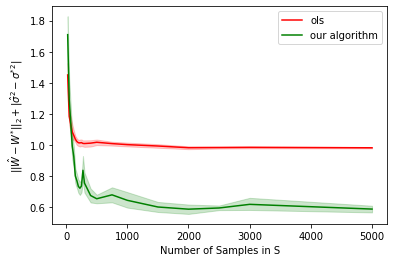

In [17]:
ax = sns.lineplot(data=ols_logs[ols_logs['num_samples'] >= 25], x='num_samples', y='ols_epsilon', label='ols', color='red')
ax = sns.lineplot(data=unknown_logs[unknown_logs['num_samples'] >= 25], x='num_samples', y='unknown_epsilon', label='our algorithm', color='green')
ax.set(xlabel='Number of Samples in S', ylabel='$||\hat W - W^{*}||_{2} + |\hat \sigma^{2} - \sigma^{*2}|$')